# Objective

This notebook aims to do the exploratory data analysis and tries to answer the questions raised as part of Task - 1.

# Prep notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import sklearn

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

from booking_forecaster.configs import params

RND = 42

# Load data

In [2]:
df_l1 = pd.read_parquet(params.DATA_PATH / "hotel_bookings_l1.parquet")

In [3]:
df_l1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149899 entries, 0 to 149898
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   hotel_name            149899 non-null  category      
 1   season                149899 non-null  category      
 2   arrival_date          149899 non-null  datetime64[ns]
 3   departure_date        149899 non-null  datetime64[ns]
 4   guest_type            149899 non-null  category      
 5   customer_type         149899 non-null  category      
 6   company               149899 non-null  int64         
 7   adr                   149899 non-null  float64       
 8   num_guests            149899 non-null  int64         
 9   adults                149899 non-null  int64         
 10  children              149899 non-null  int64         
 11  babies                149899 non-null  int64         
 12  meal                  149899 non-null  category      
 13 

In [4]:
df_l1['company'] = df_l1['company'].astype('category')

# Start exploration

## Which countries are the most guests from?

Before starting to answer the above question we should start looking into how many unique countries we have in our dataset?

In [5]:
df_l1['source_country'].nunique()

170

170 is actually a big number, we may need to do some sensible filtering later. But first, we will calculate the counts as is.

In [6]:
df_country_stats = (df_l1
 .groupby('source_country', as_index=False)
 .agg({"num_guests": 'sum'})
 .rename(columns={"num_guests": 'cnt'})
 .sort_values('cnt', ascending=False)
)

/tmp/ipykernel_78064/2794588726.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_stats = (df_l1


In [7]:
df_country_stats

source_country     cnt
129            PRT  117189
56             GBR   30516
53             FRA   26650
48             ESP   22210
40             DEU   17809
..             ...     ...
116            NIC       2
119            NPL       2
136            SDN       2
158            UGA       1
86             KNA       1

[170 rows x 2 columns]

From the surface it looks like we are getting maximum number of guests from **PRT** (Portugal).

Let's now only consider the records where the bookings were *not cancelled*.

In [8]:
df_country_stats_filtered = (df_l1
 .loc[~df_l1['is_canceled']]
 .groupby('source_country', as_index=False)
 .agg({"num_guests": 'sum'})
 .rename(columns={"num_guests": 'cnt'})
 .sort_values('cnt', ascending=False)
)

/tmp/ipykernel_78064/1873026526.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_stats_filtered = (df_l1


In [9]:
df_country_stats_filtered

source_country    cnt
129            PRT  64492
56             GBR  22918
53             FRA  20146
48             ESP  15834
40             DEU  13649
..             ...    ...
84             KHM      0
79             JEY      0
165            VGB      0
70             IMN      0
112            MYT      0

[170 rows x 2 columns]

So we could conclude that the stats don't change - the top 5 countries (and their relative ranks) still remain the same.

In [10]:
df_country_stats_filtered['proportion'] = df_country_stats_filtered['cnt'] / df_country_stats_filtered['cnt'].sum()

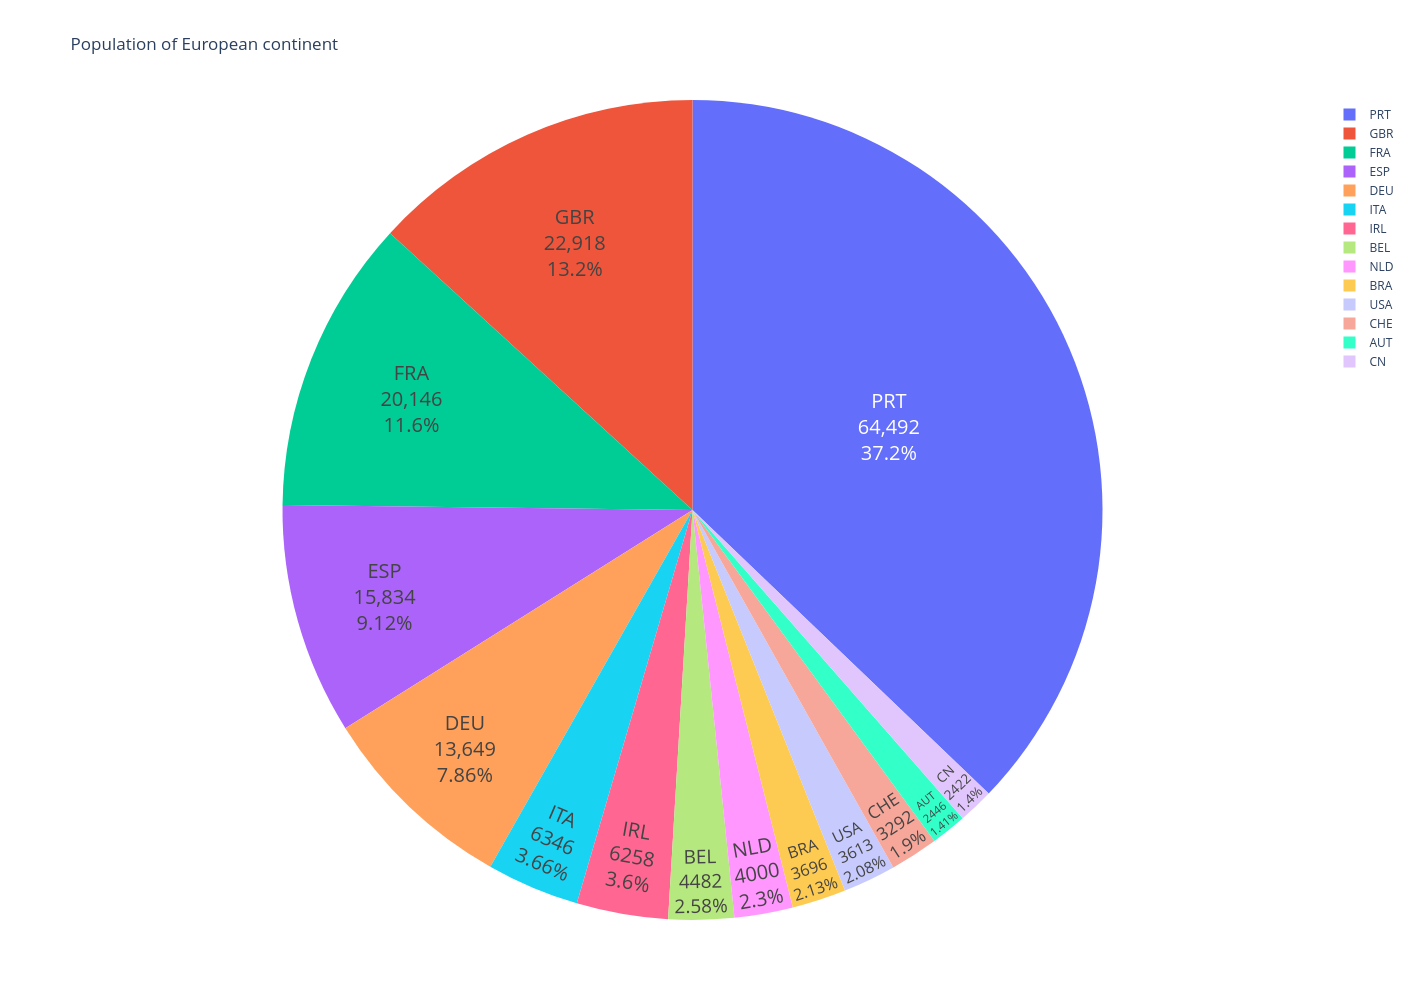

In [11]:
fig = px.pie(
    df_country_stats_filtered.loc[df_country_stats_filtered['proportion']>=0.01], 
    values='cnt',
    names='source_country',
    title='Population of European continent',
    labels='source_country',
    hover_data=['cnt'],
    width=1000, 
    height=1000
)
fig.update_traces(textposition='inside', textinfo='percent+label+value', textfont_size=20)
fig.show()

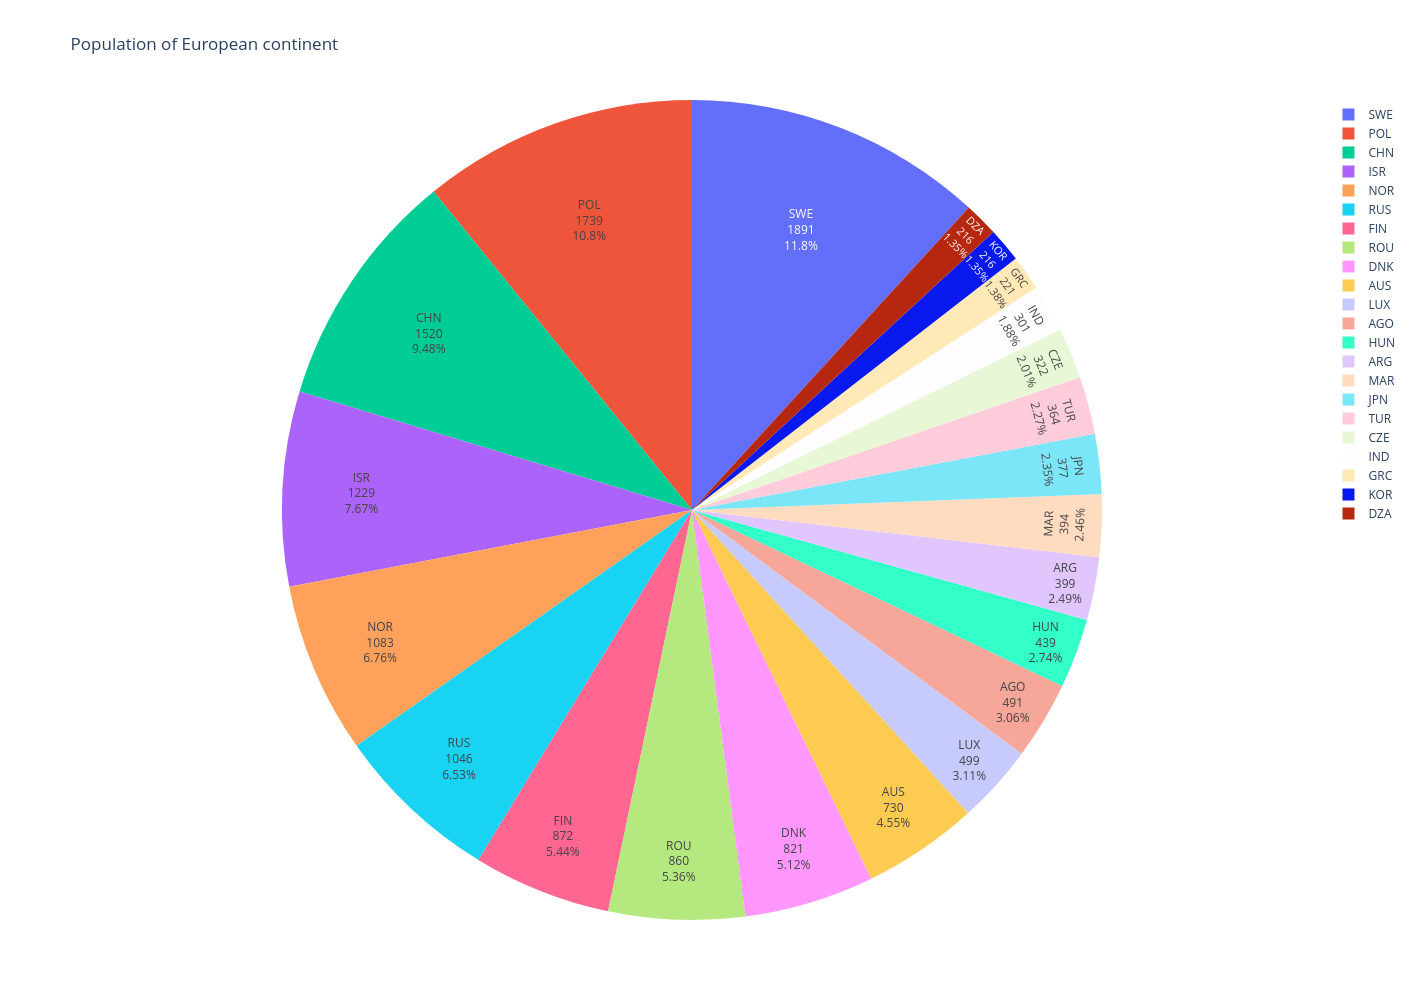

In [12]:
fig = px.pie(
    df_country_stats_filtered.loc[
        (df_country_stats_filtered['proportion']<0.01) &
        (df_country_stats_filtered['proportion']>=0.001)
    ], 
    values='cnt',
    names='source_country',
    title='Population of European continent',
    labels='source_country',
    hover_data=['cnt'],
    width=1000, 
    height=1000
)
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()

In [6]:
df_l2 = df_l1.copy(deep=True)

## Along which dimensions do guests from different source countries differ the most?

There are a couple of ways to address this question:
1. Using statistical methods:   
    a. Conducting one-way ANOVA for the numerical features - with this we try and measure the impact of `source_country` on different numerical features.   
    b. Conducting a $\chi^2$ test for each of the categorical features.


2. Use a machine learning model (preferrably something like a Decision Tree) keeping `source_country` as the target variable - models like these don't rely on any assumptions regarding the underlying distribution of the dataset and are also able to work the cross-interaction effects of the predictor variables. P.S. here we won't do any train-test split and rather would like to overfit the model. This is in complete contradiction with how generally ML is applied to problems but this is a special scenario.

Please note the approach in 1a. would only work if we can ensure that the data in the numerical features are normally distributed. 

But before we jump into the analysis, let's add a few more features to our dataset.

In [7]:
# add date attributes
date_cols = df_l2.select_dtypes('datetime').columns

In [8]:
for col in date_cols:
    df_l2[f"{col}_year"] = df_l2[col].dt.year
    df_l2[f"{col}_month"] = df_l2[col].dt.month
    df_l2[f"{col}_dom"] = df_l2[col].dt.day
    df_l2[f"{col}_dow"] = df_l2[col].dt.dayofweek
    df_l2[f"{col}_quarter"] = df_l2[col].dt.quarter
    df_l2[f"{col}_doy"] = df_l2[col].dt.dayofyear
    df_l2[f"{col}_woy"] = df_l2[col].dt.isocalendar().week
    df_l2[f"{col}_year_week"] = df_l2.apply(lambda x: int(str(x[f"{col}_year"]) + str(x[f"{col}_woy"]).zfill(2)), axis=1)
    df_l2[f"{col}_year_month"] = df_l2.apply(lambda x: int(str(x[f"{col}_year"]) + str(x[f"{col}_month"]).zfill(2)), axis=1)

In [9]:
# add booking duration
df_l2["booking_duration"] = (df_l2["departure_date"] - df_l2["arrival_date"]).dt.days

In [10]:
# add how many days it has been booked before actual arrival
df_l2["n_days_booked_pre_arrival"] = (df_l2["arrival_date"] - df_l2["booking_date"]).dt.days

In [11]:
df_l2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149899 entries, 0 to 149898
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   hotel_name                 149899 non-null  category      
 1   season                     149899 non-null  category      
 2   arrival_date               149899 non-null  datetime64[ns]
 3   departure_date             149899 non-null  datetime64[ns]
 4   guest_type                 149899 non-null  category      
 5   customer_type              149899 non-null  category      
 6   company                    149899 non-null  category      
 7   adr                        149899 non-null  float64       
 8   num_guests                 149899 non-null  int64         
 9   adults                     149899 non-null  int64         
 10  children                   149899 non-null  int64         
 11  babies                     149899 non-null  int64   

In [19]:
# save the dataset
df_l2.to_parquet(params.DATA_PATH / 'hotel_bookings_l2.parquet', index=False)

In [20]:
numeric_cols = df_l2.select_dtypes(['float', 'int']).columns

In [21]:
cat_cols = df_l2.select_dtypes('category').columns

In [22]:
# let's focus on the bookings which were not cancelled
df_l3 = df_l2.loc[~df_l2['is_canceled']].reset_index(drop=True).copy()

### Statistical methods

#### Test for numerical features

##### Check the distribution

/tmp/ipykernel_78064/1589616555.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



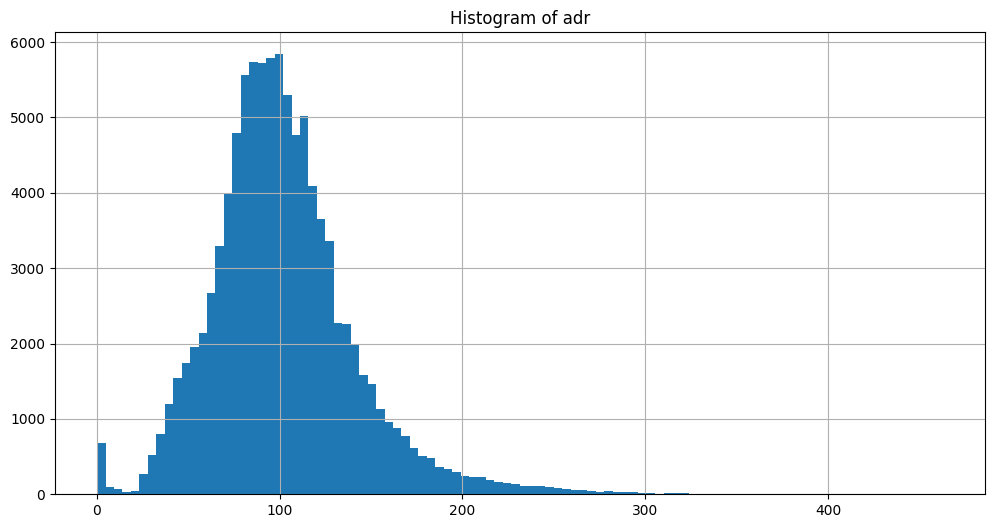

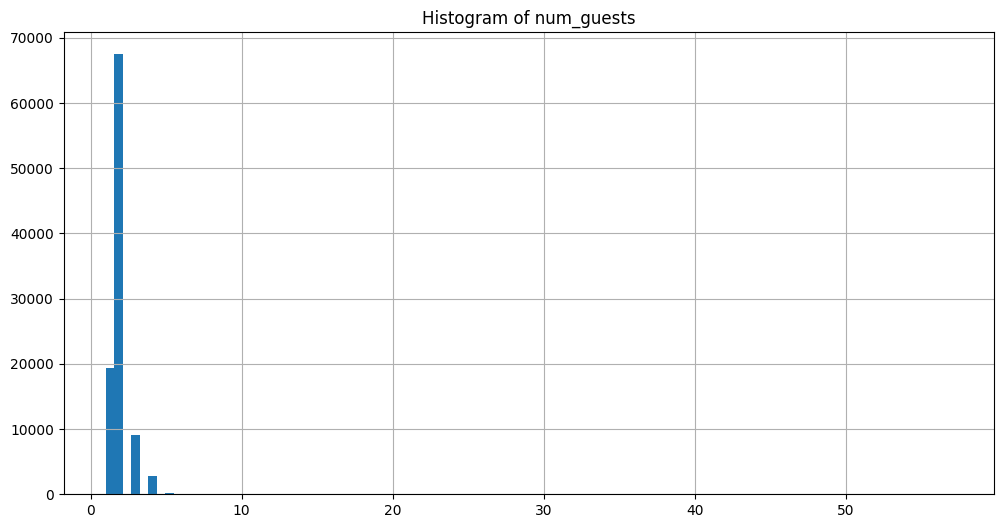

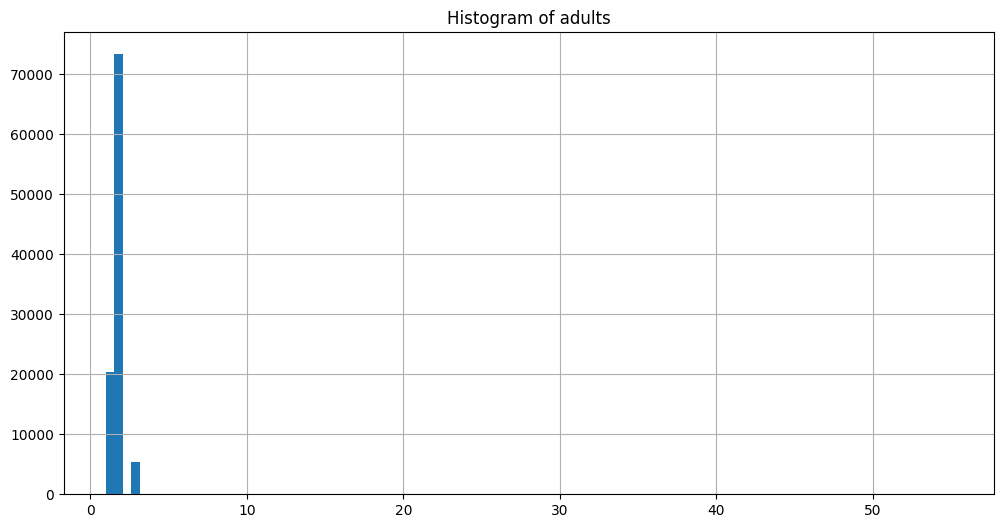

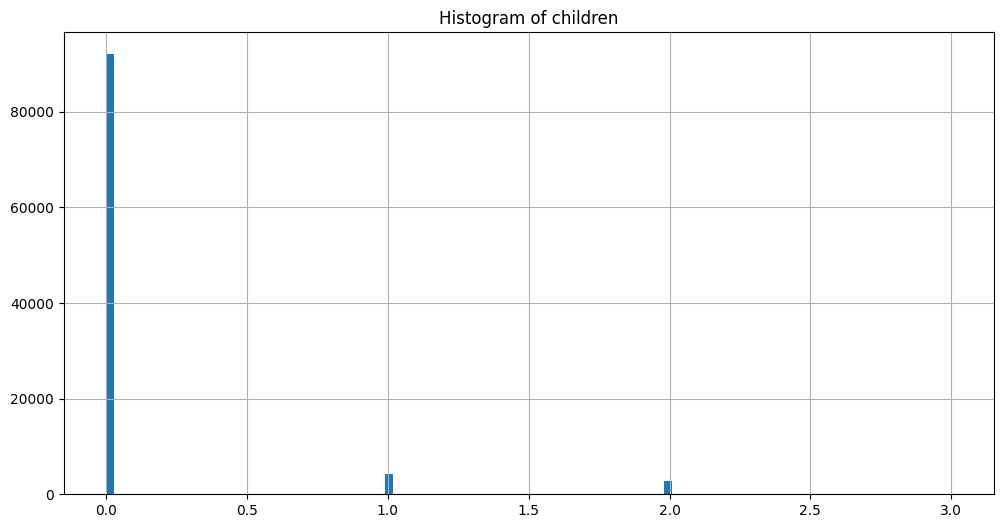

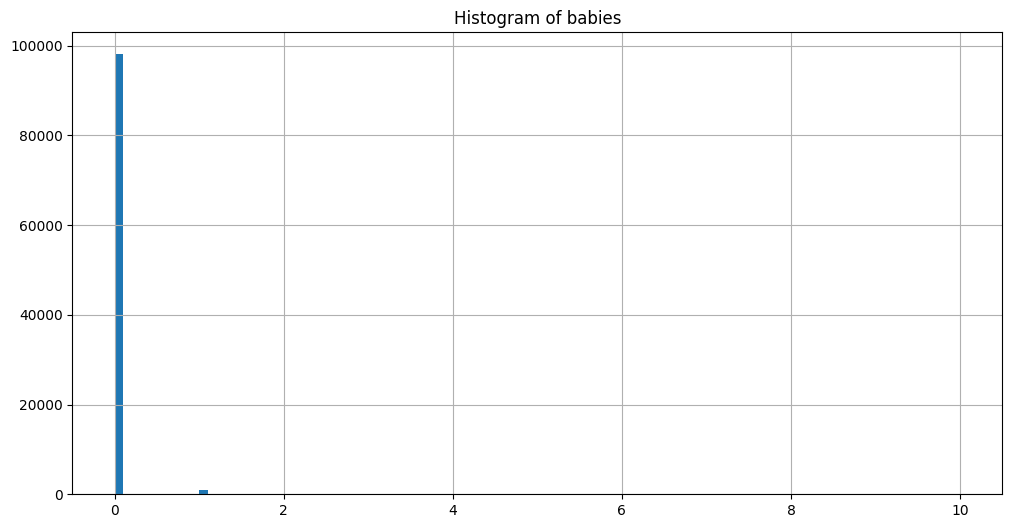

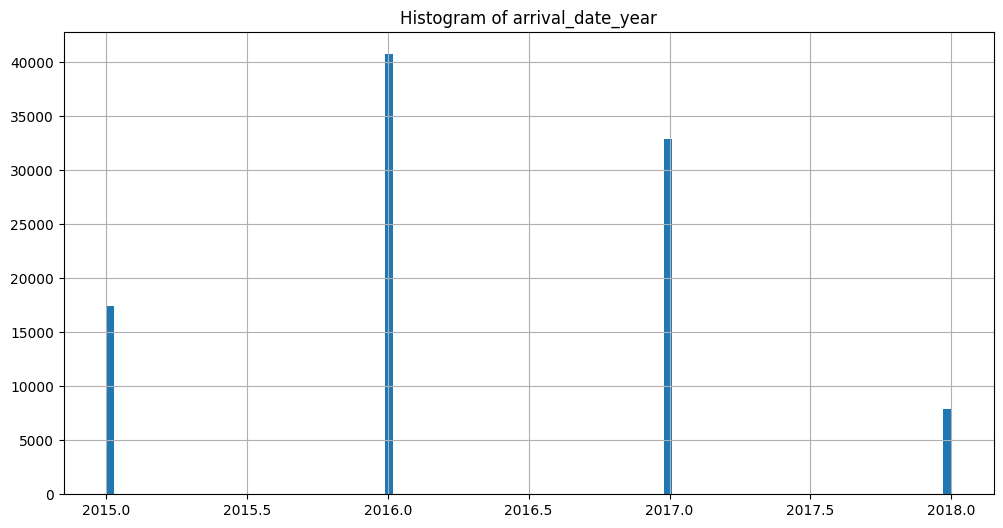

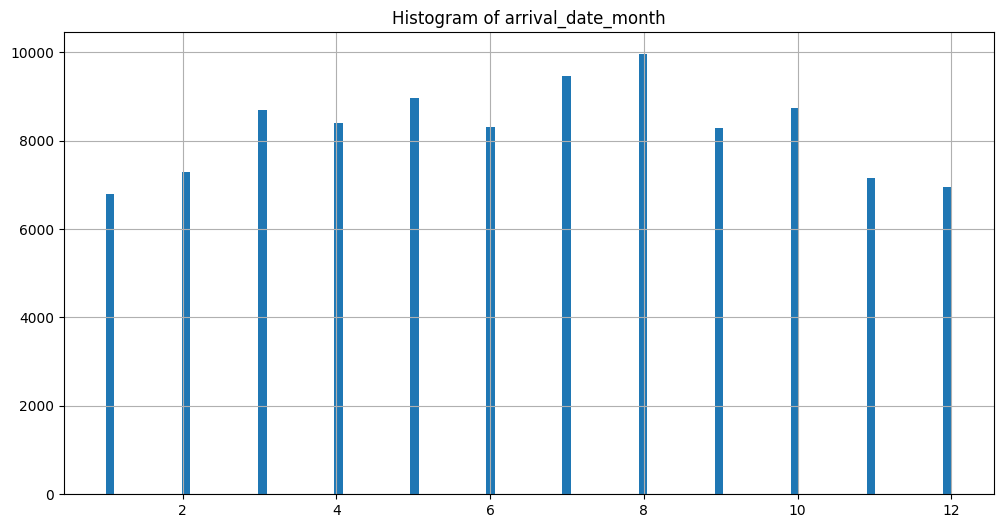

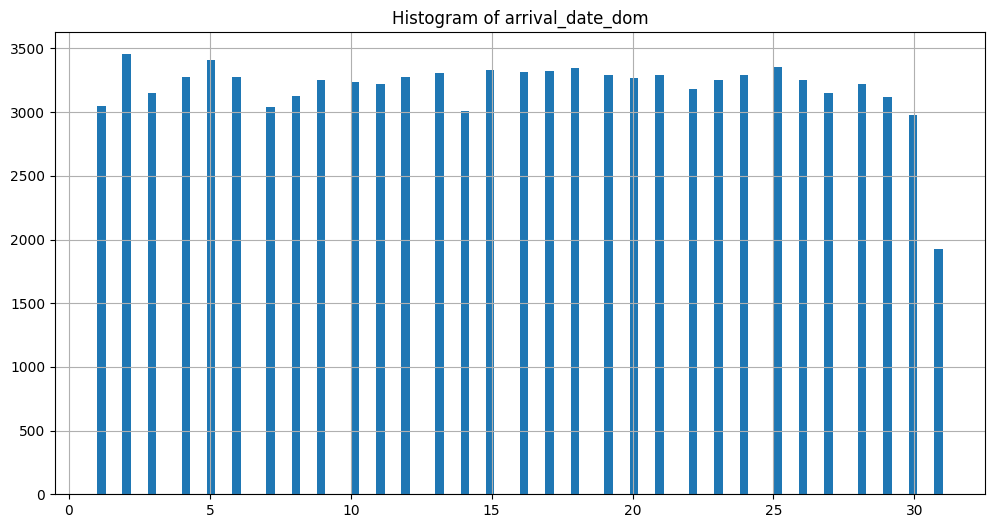

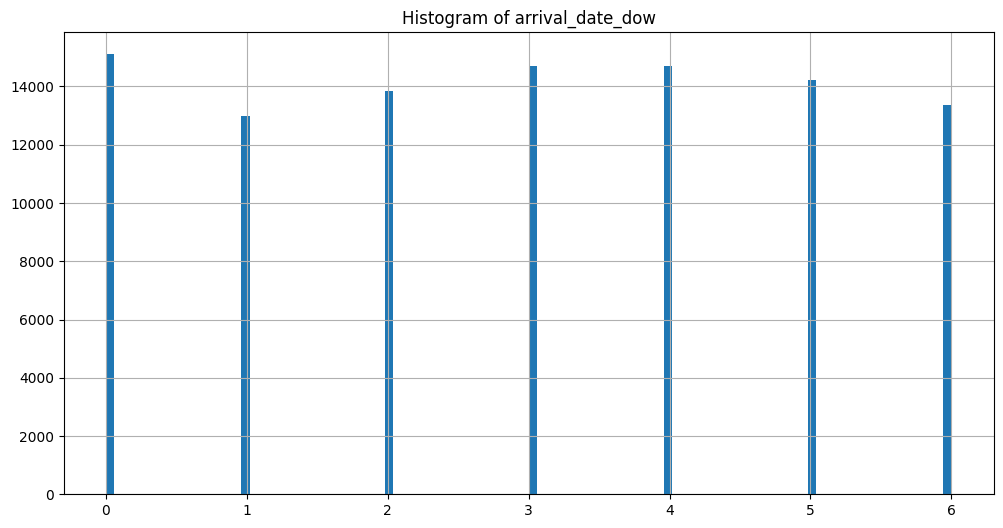

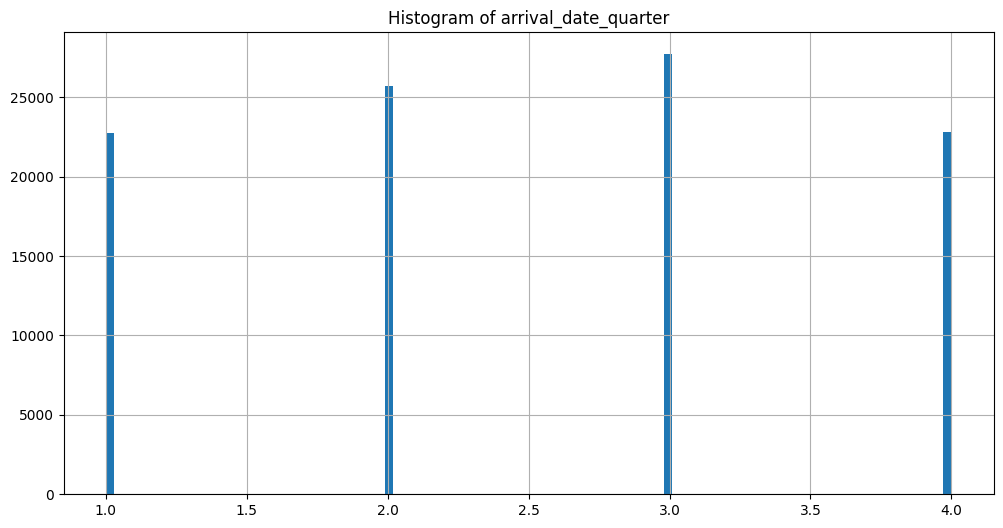

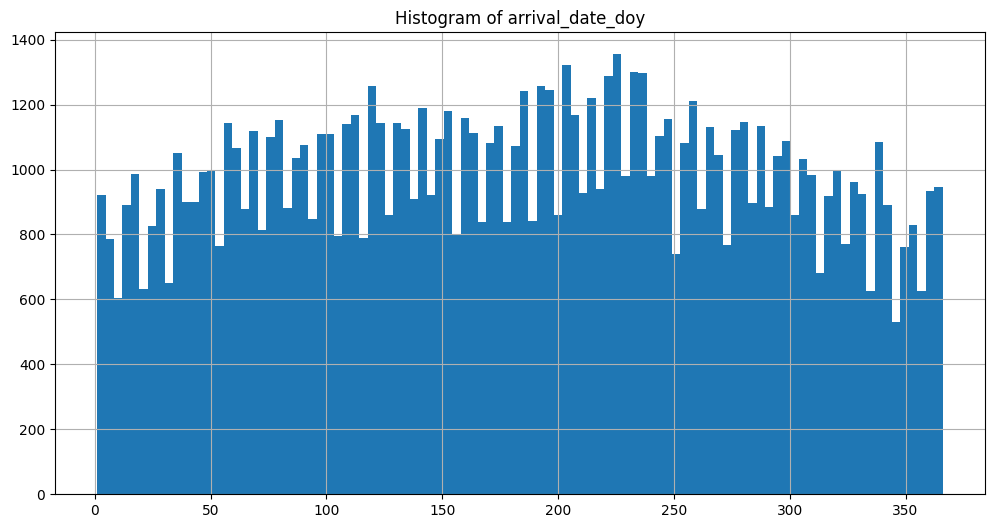

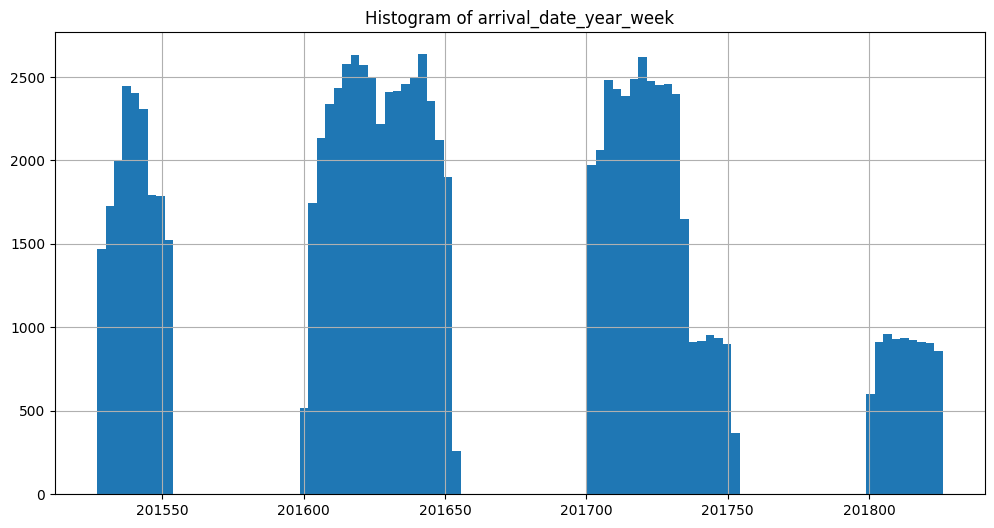

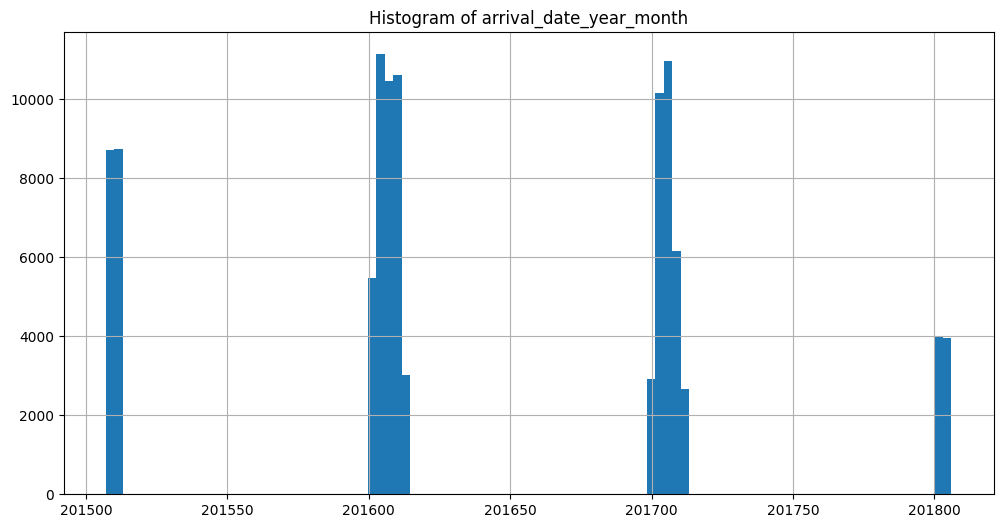

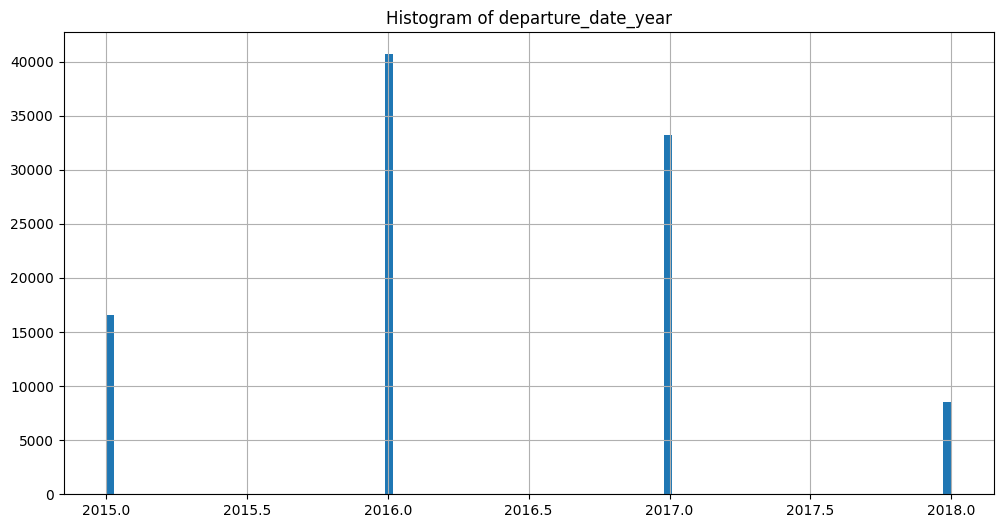

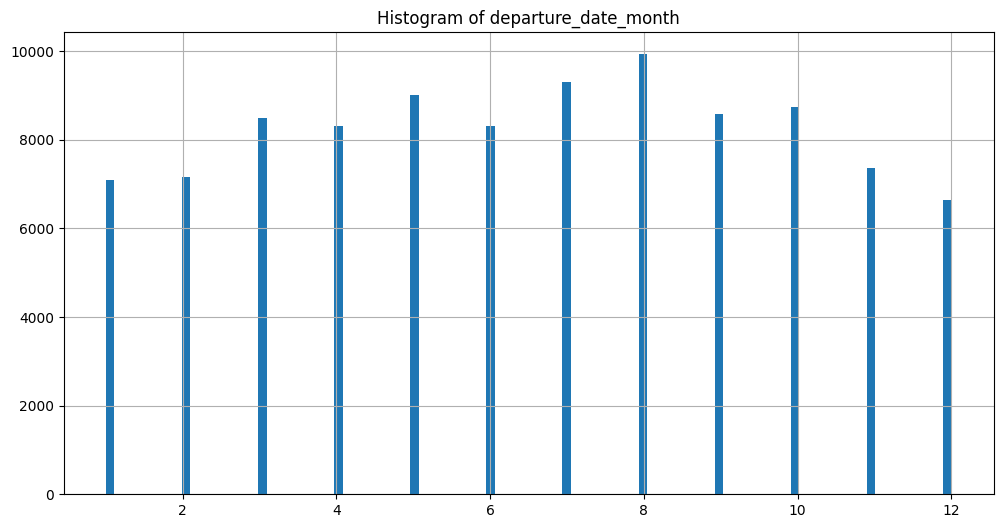

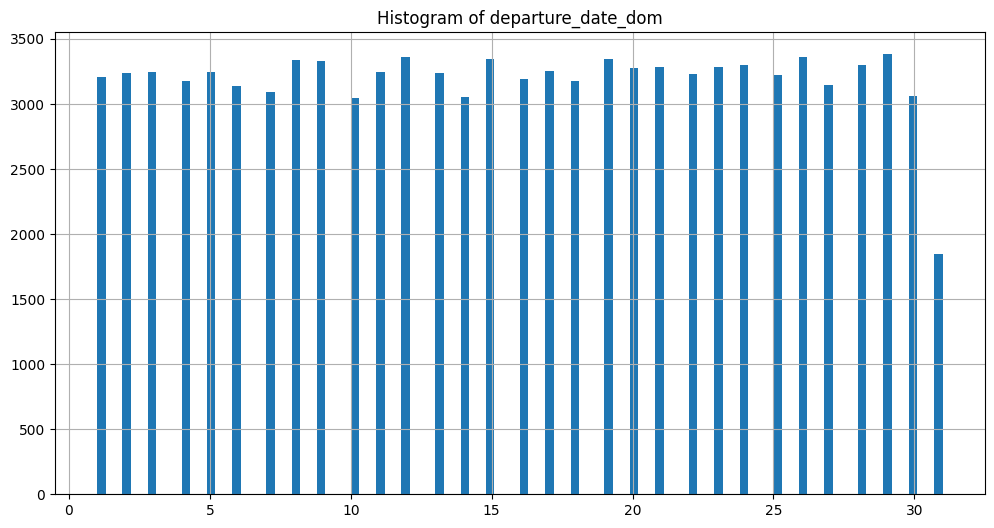

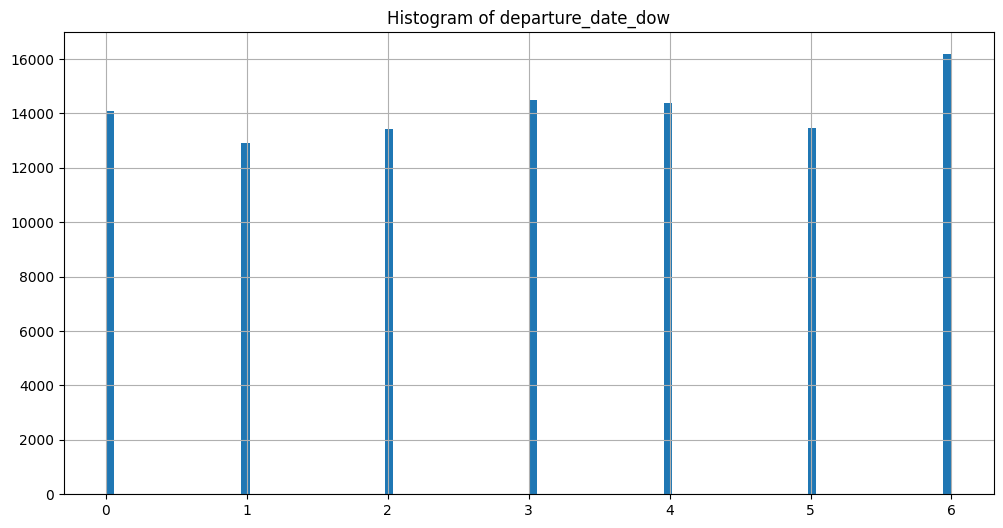

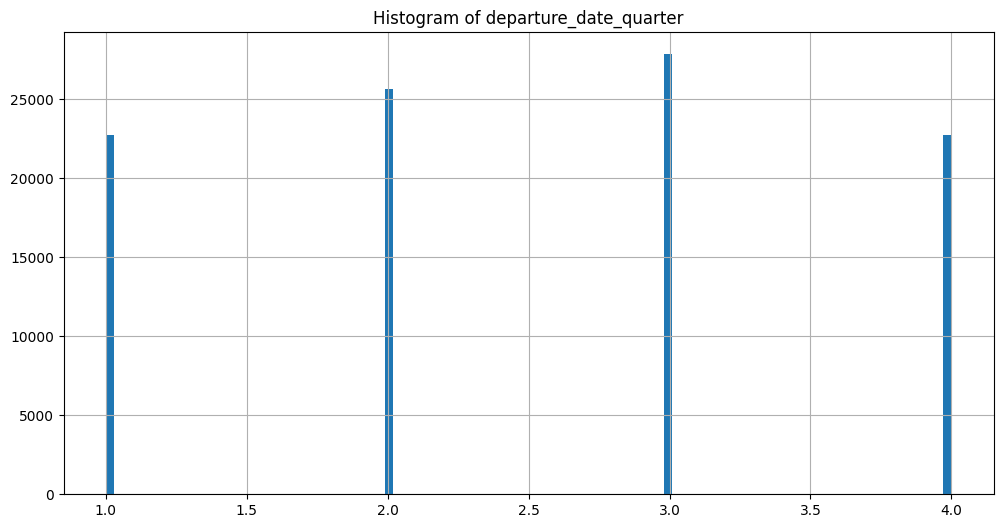

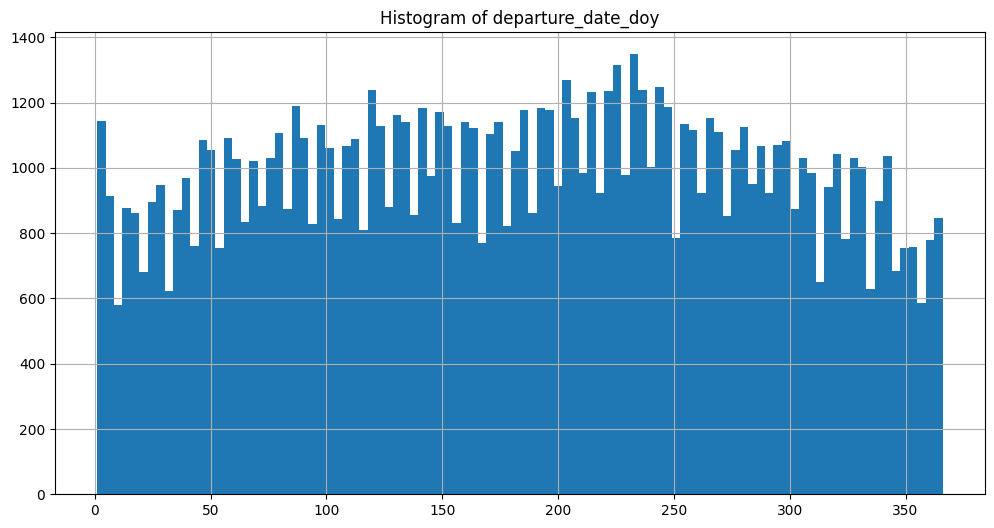

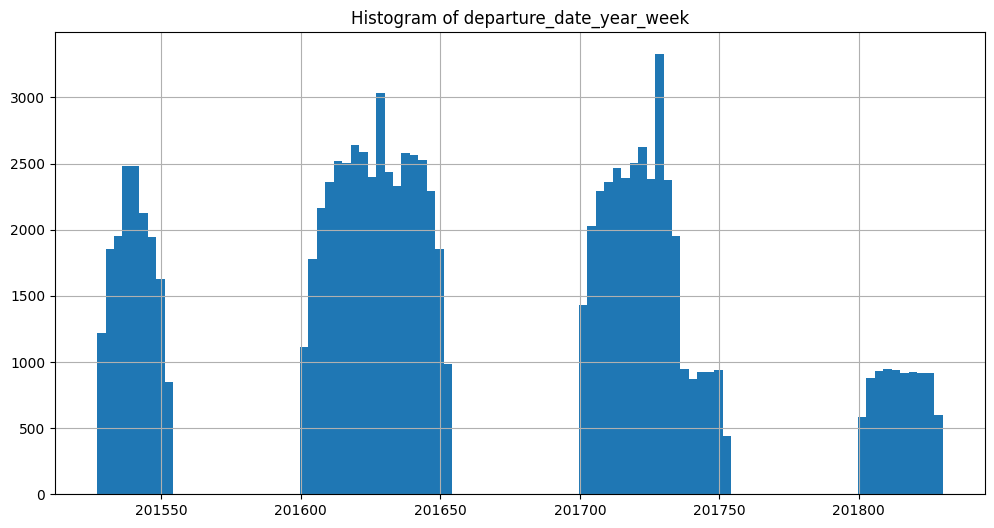

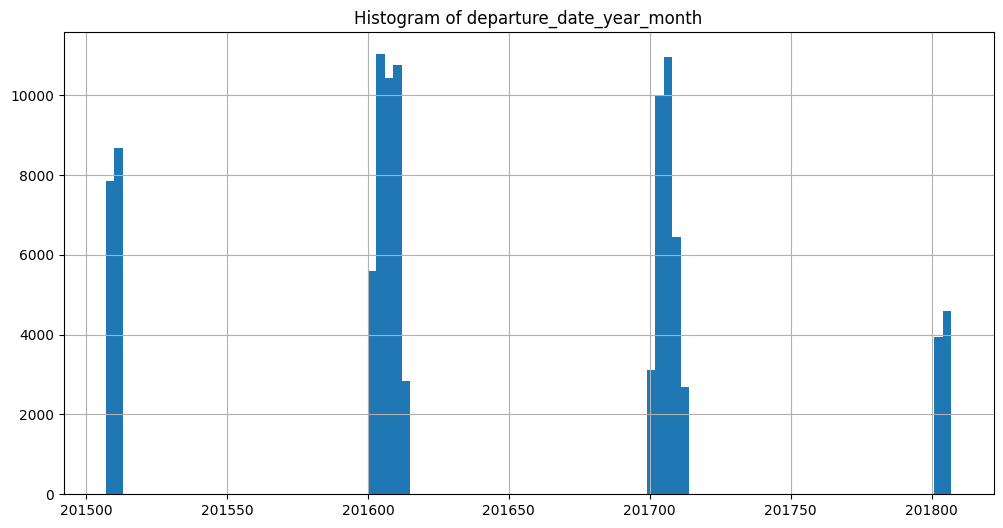

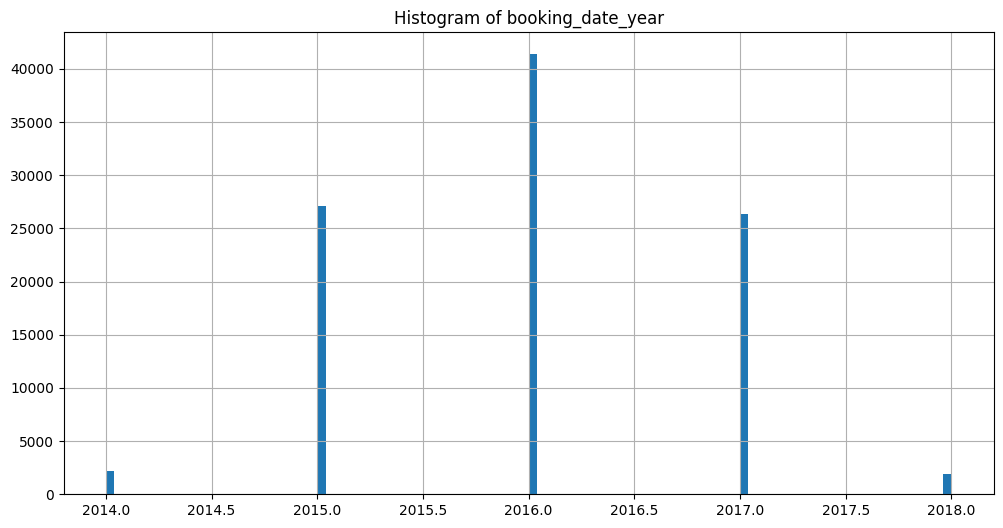

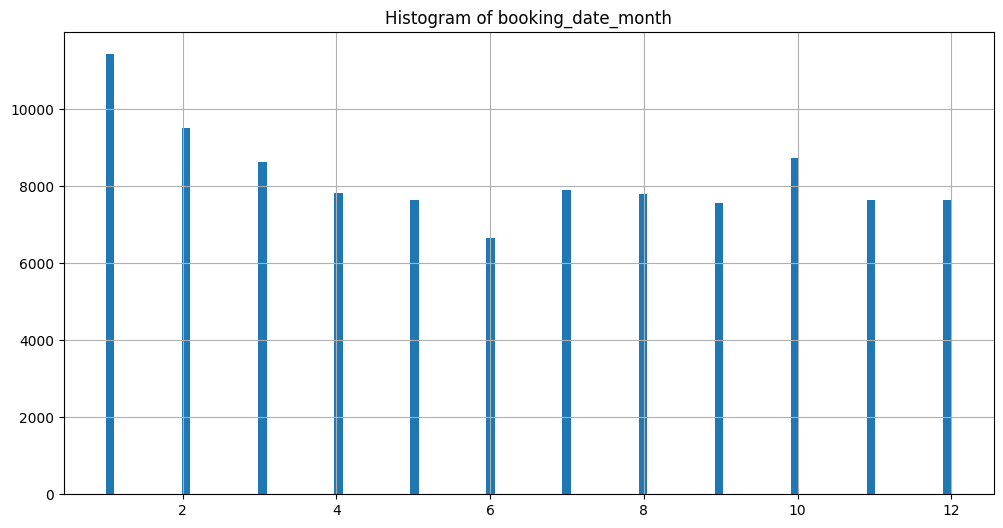

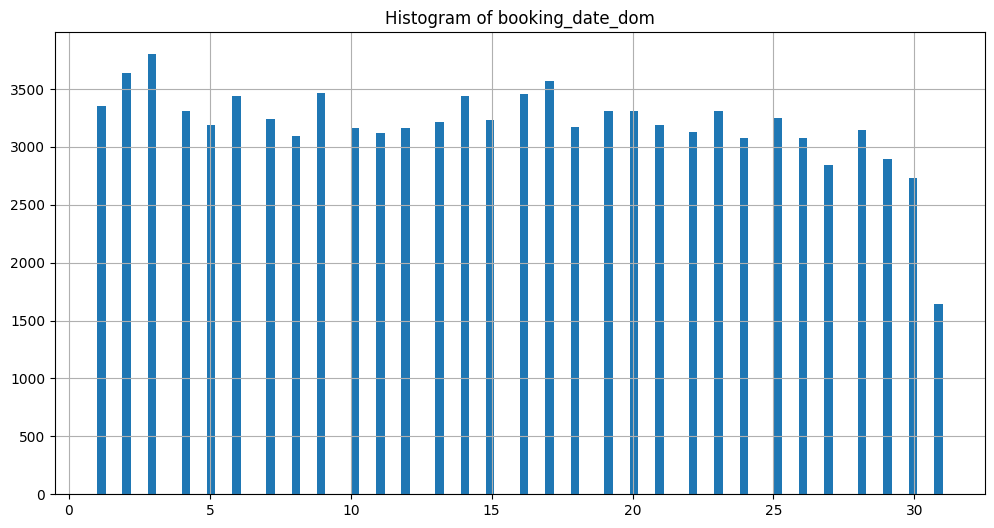

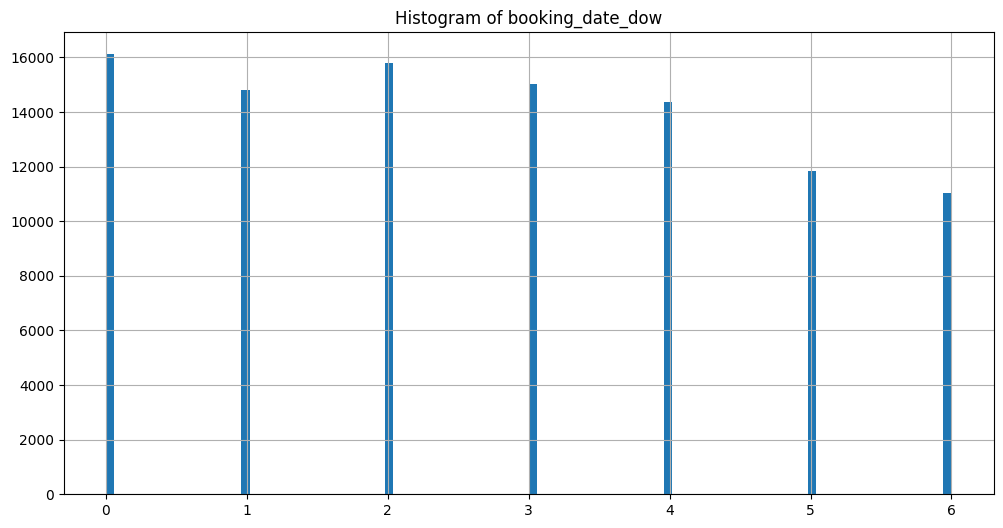

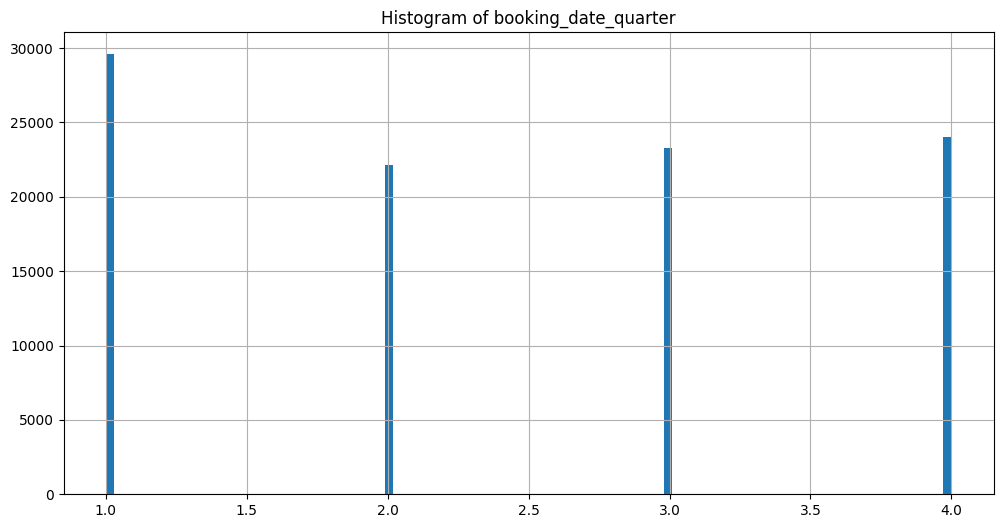

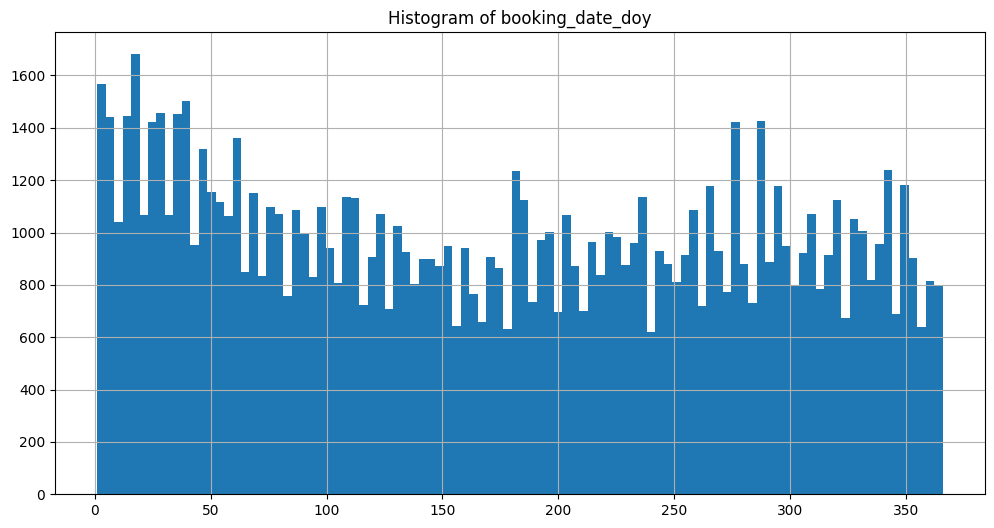

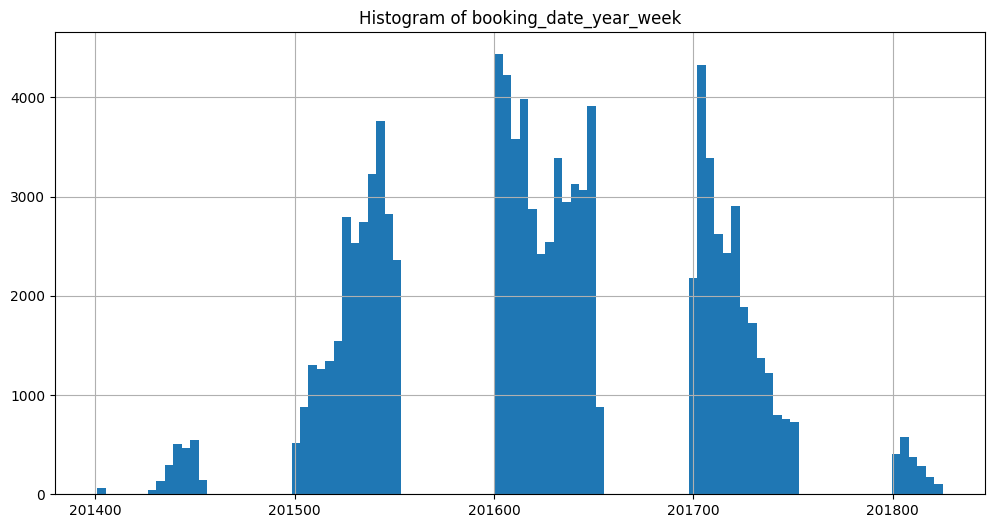

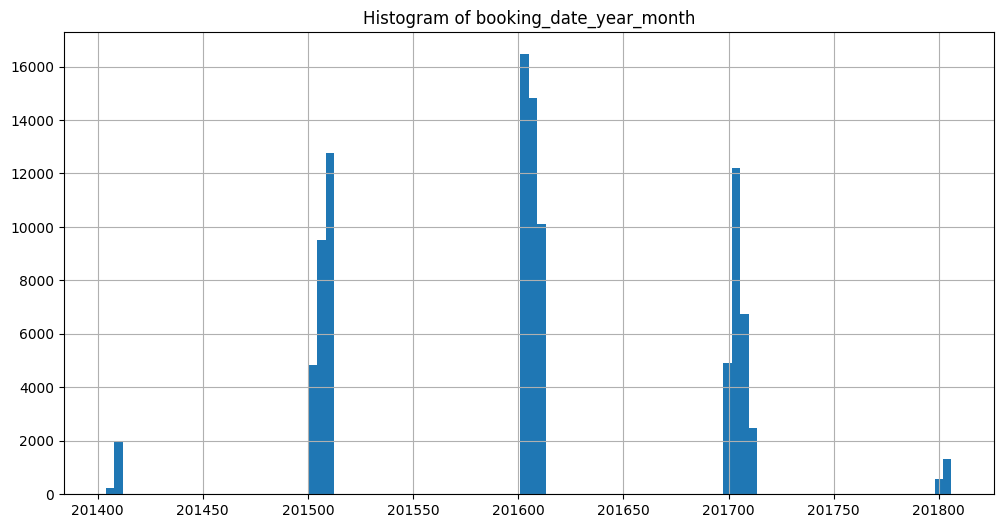

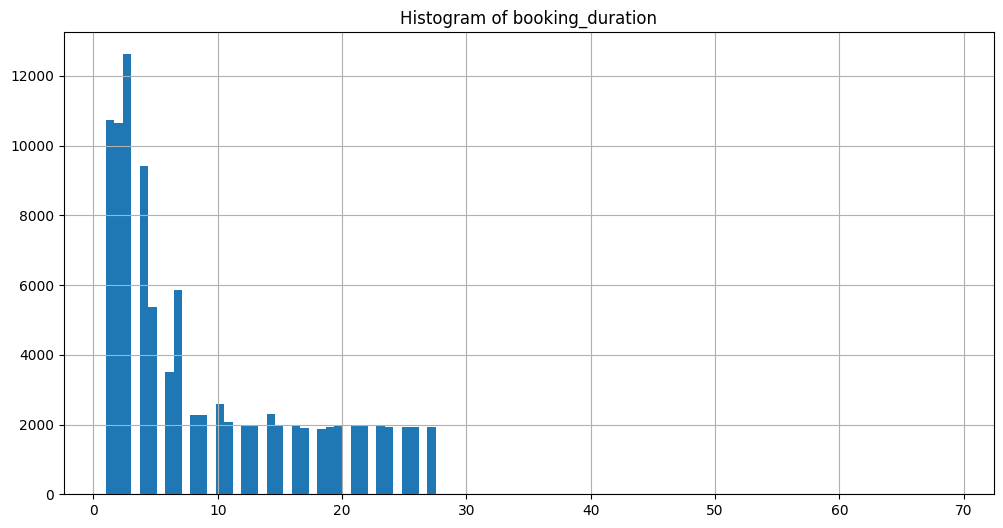

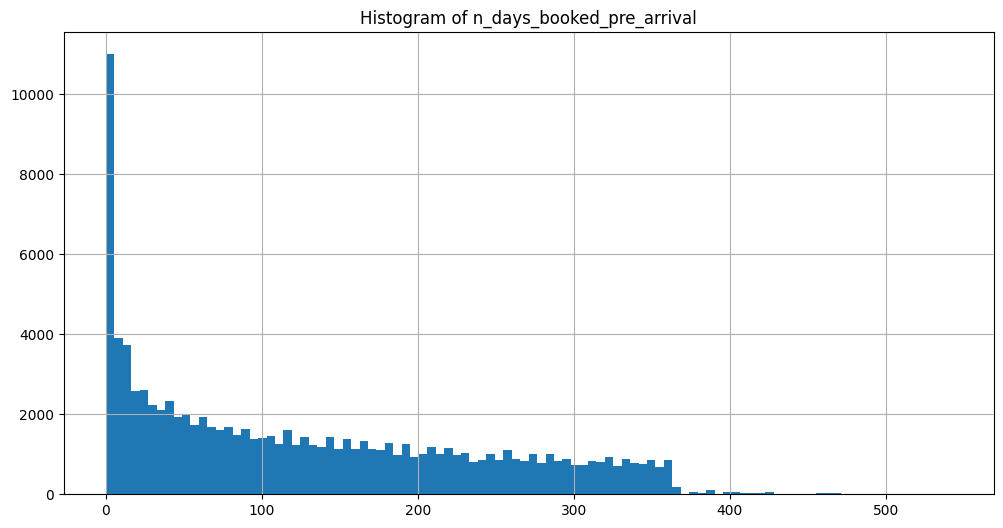

In [23]:
for feature in numeric_cols:
    plt.figure(figsize=(12, 6))
    plt.hist(df_l3[feature], bins=100)
    plt.title(f'Histogram of {feature}')
    plt.grid(True)

Although, we could conduct another hypothesis test (like `shapiro`) on each of the numerical feature but in this case for the sake of brevity I would conclude that apart from a few features (like `adr`, `num_guests` etc.) most seem to be not "normally" distributed. So we could skip the ANOVA.

The features - `booking_duration` and `n_days_booked_pre_arrival` look different - both of them have a thick right tail (like a one-sided Student's t).

The date derived features are mostly uniform except for `*_year` which peaks at 2016.

Here are a few more observations:
1. Most of the time the booking duration is 5-7 days.
2. Most bookings happen at beginning of the year.
3. Most stays happen during the 7th month which corresponds to the Summer time in EU - this aligns with the general knowledge.
4. Most of the time the `num_guests` is 2.
5. Mostly booking are spontaneous i.e. booked a few days before arrival.

#### Test for categorical features

##### Check distributions

In [24]:
cat_cols_ = list(cat_cols)
cat_cols_.remove('source_country')

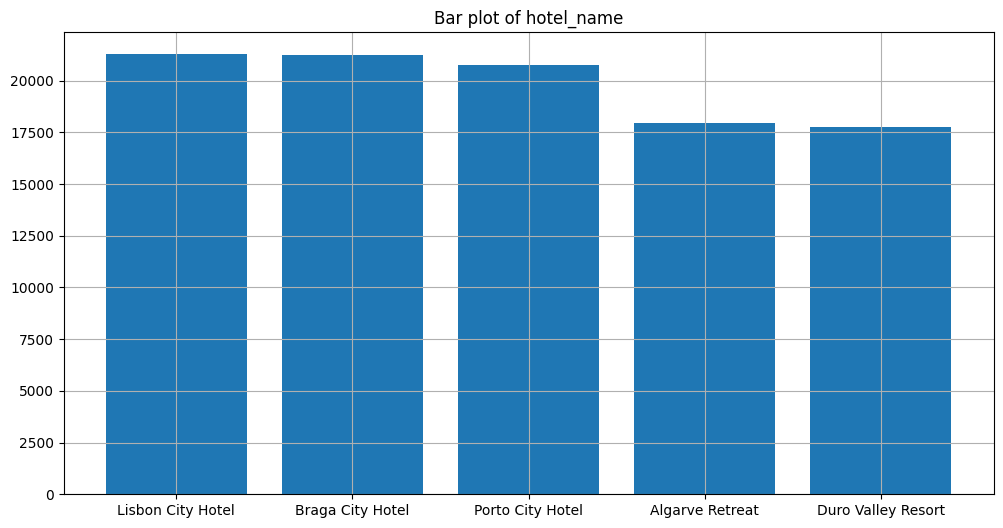

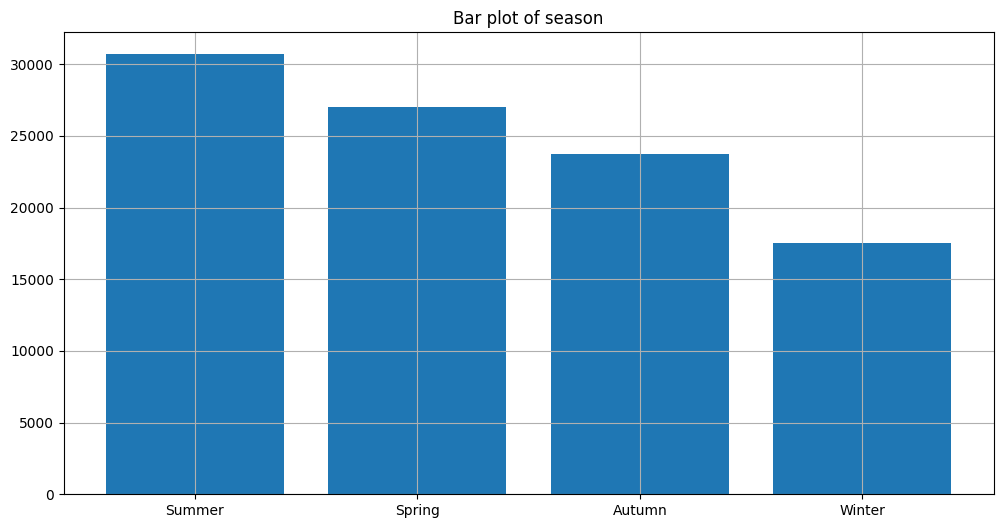

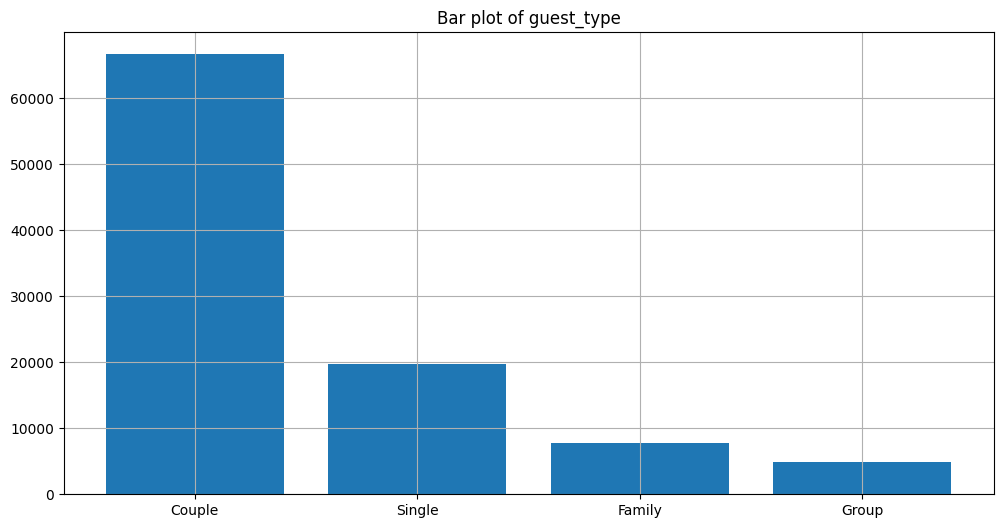

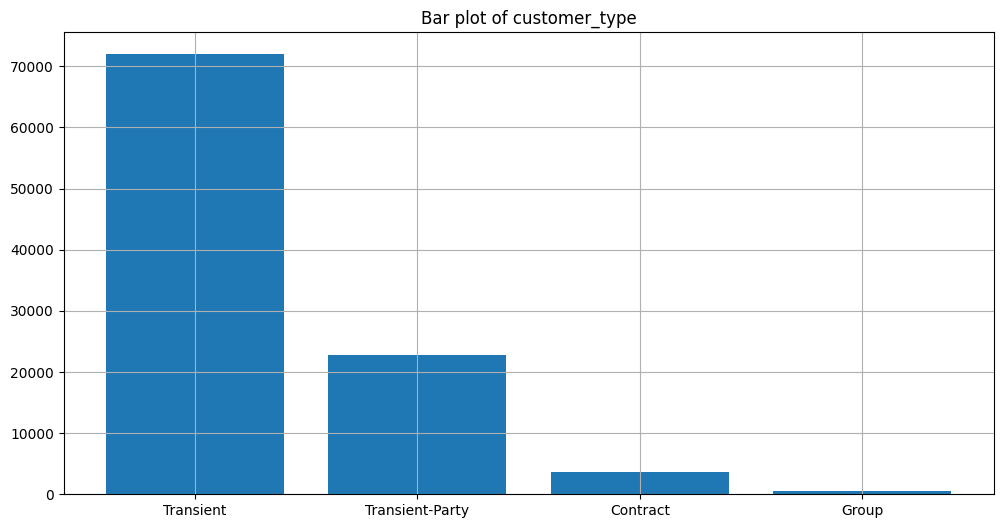

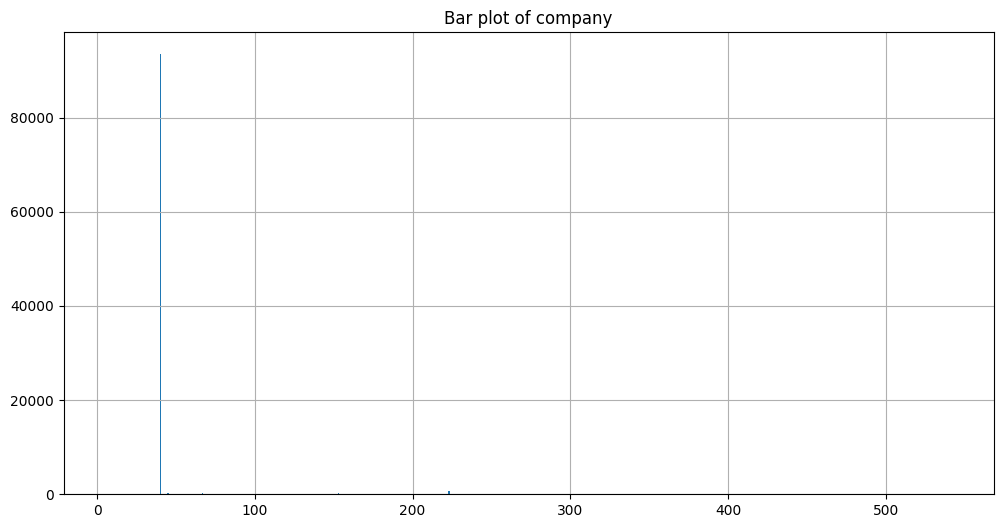

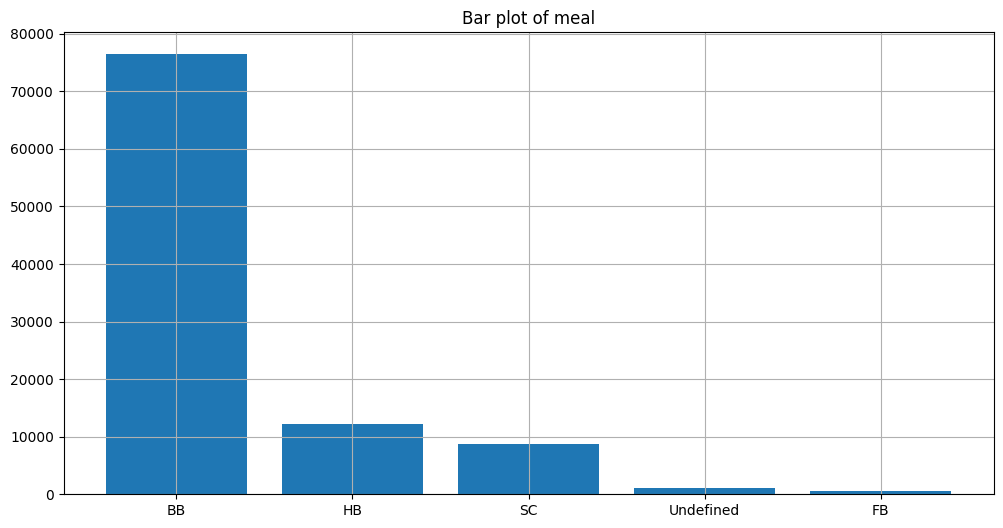

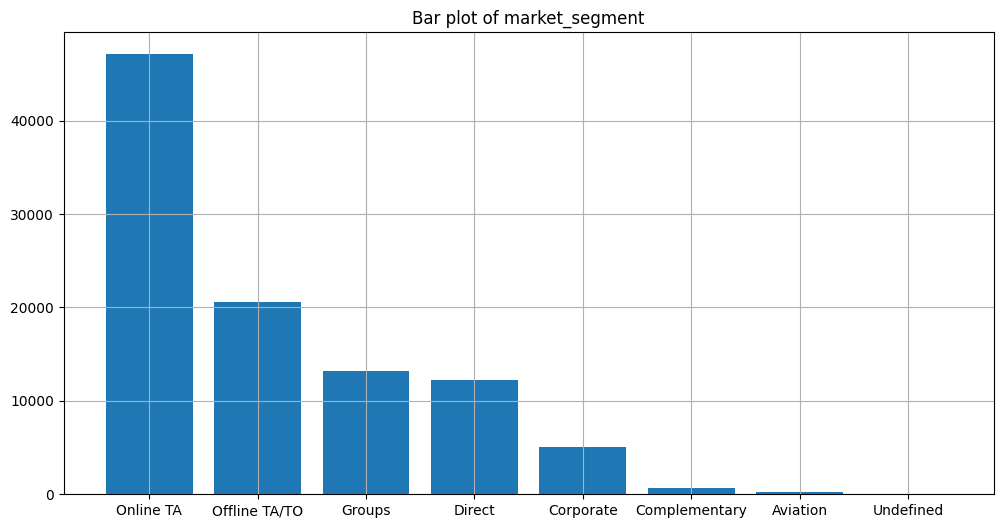

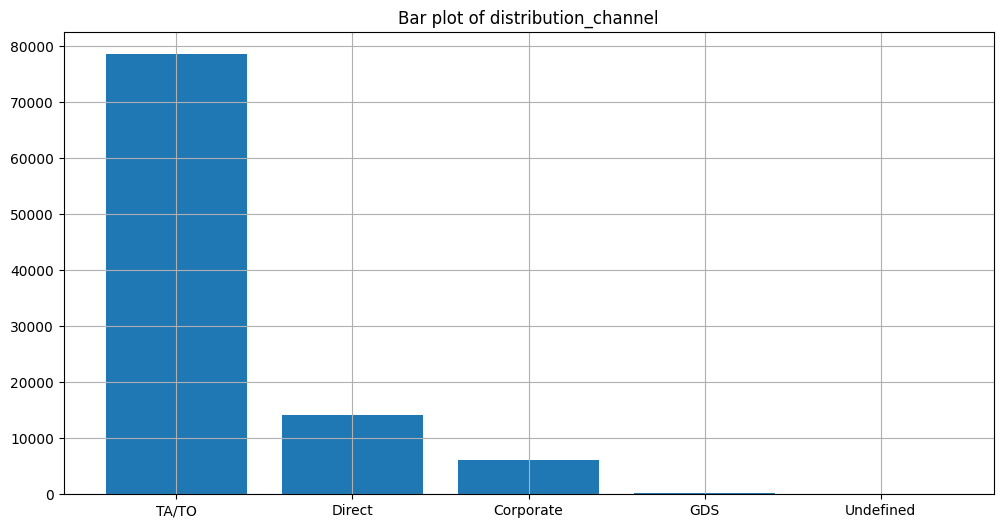

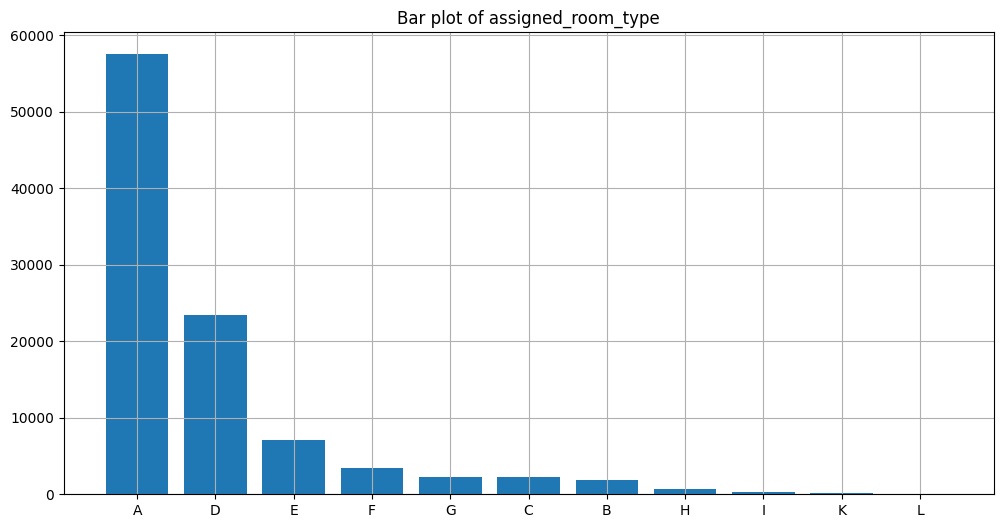

In [25]:
for col in cat_cols_:
    vals = df_l3[col].value_counts()
    plt.figure(figsize=(12, 6))
    plt.bar(vals.index, vals.values)
    plt.title(f"Bar plot of {col}")
    plt.grid(True)

##### Conduct Chi-square

In [26]:
p_values = {}

for col in cat_cols_:
    contingency_table = pd.crosstab(df_l3[col], df_l3['source_country'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_values[col] = p

p_values_series = pd.Series(p_values).sort_values()

print("P-values for Chi-Square test:")
print(p_values_series)

P-values for Chi-Square test:
hotel_name               0.000000e+00
market_segment           0.000000e+00
distribution_channel    5.115316e-305
company                 1.632918e-270
guest_type              1.475011e-237
customer_type           2.633993e-233
meal                    3.503098e-193
season                  1.171579e-147
assigned_room_type       5.584680e-22
dtype: float64


From the values, since all of them have p-value < 0.05, they all have a significant association with `source_country`. 

Intuitively speaking the above conclusion does not look trustworthy. 

Let's look a it from a different perspective in the next sub-section.

### Using machine learning

In [27]:
df_ = df_l3.copy()

for col in cat_cols:
    df_[col] = LabelEncoder().fit_transform(df_[col])

In [28]:
input_cols = list(numeric_cols)+list(cat_cols)
input_cols.remove('source_country')

mdl = DecisionTreeClassifier(random_state=RND)
mdl.fit(df_[input_cols], df_['source_country'])

DecisionTreeClassifier(random_state=42)

In [29]:
# since there are 170 classes and the dataset is quite unbalanced (as observed in the last section) we could use a score which is robust to it
# just to check if our model has fit or not
sklearn.metrics.balanced_accuracy_score(mdl.predict(df_[input_cols]), df_['source_country'], adjusted=True)

0.9999895212845477

Now, that the model has fit let's look at the feature importances.

In [30]:
df_imp = pd.DataFrame({"feature": input_cols, "importance": mdl.feature_importances_}).sort_values('importance', ascending=False)

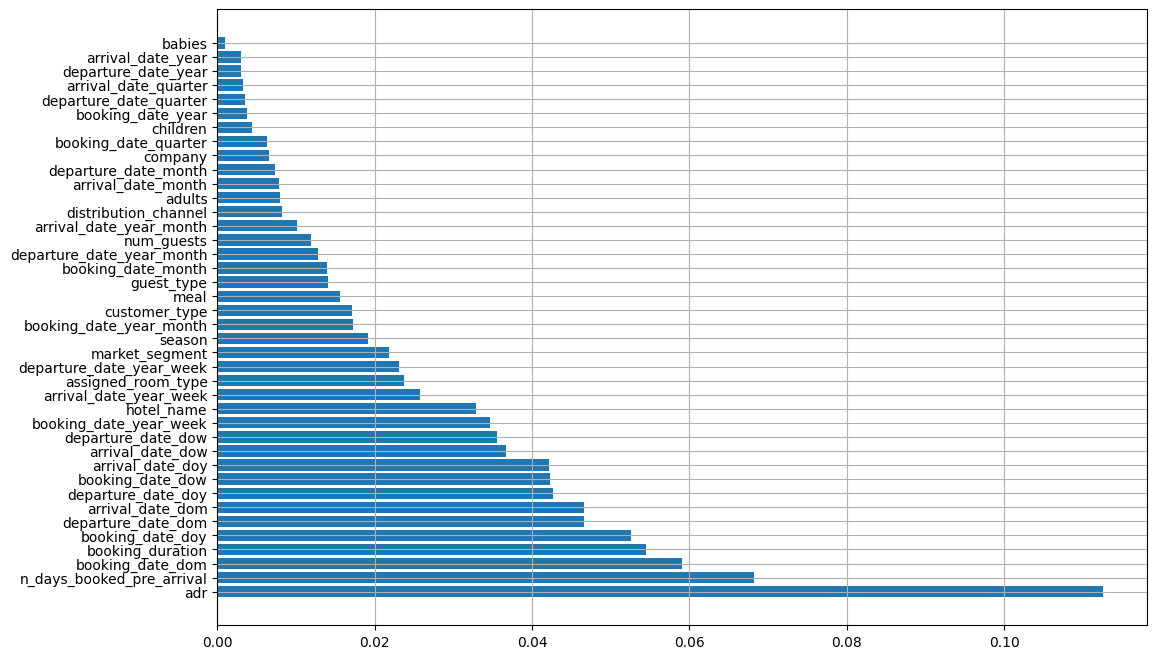

In [31]:
plt.figure(figsize=(12, 8))
plt.barh(df_imp['feature'], width=df_imp['importance'])
plt.grid(True)

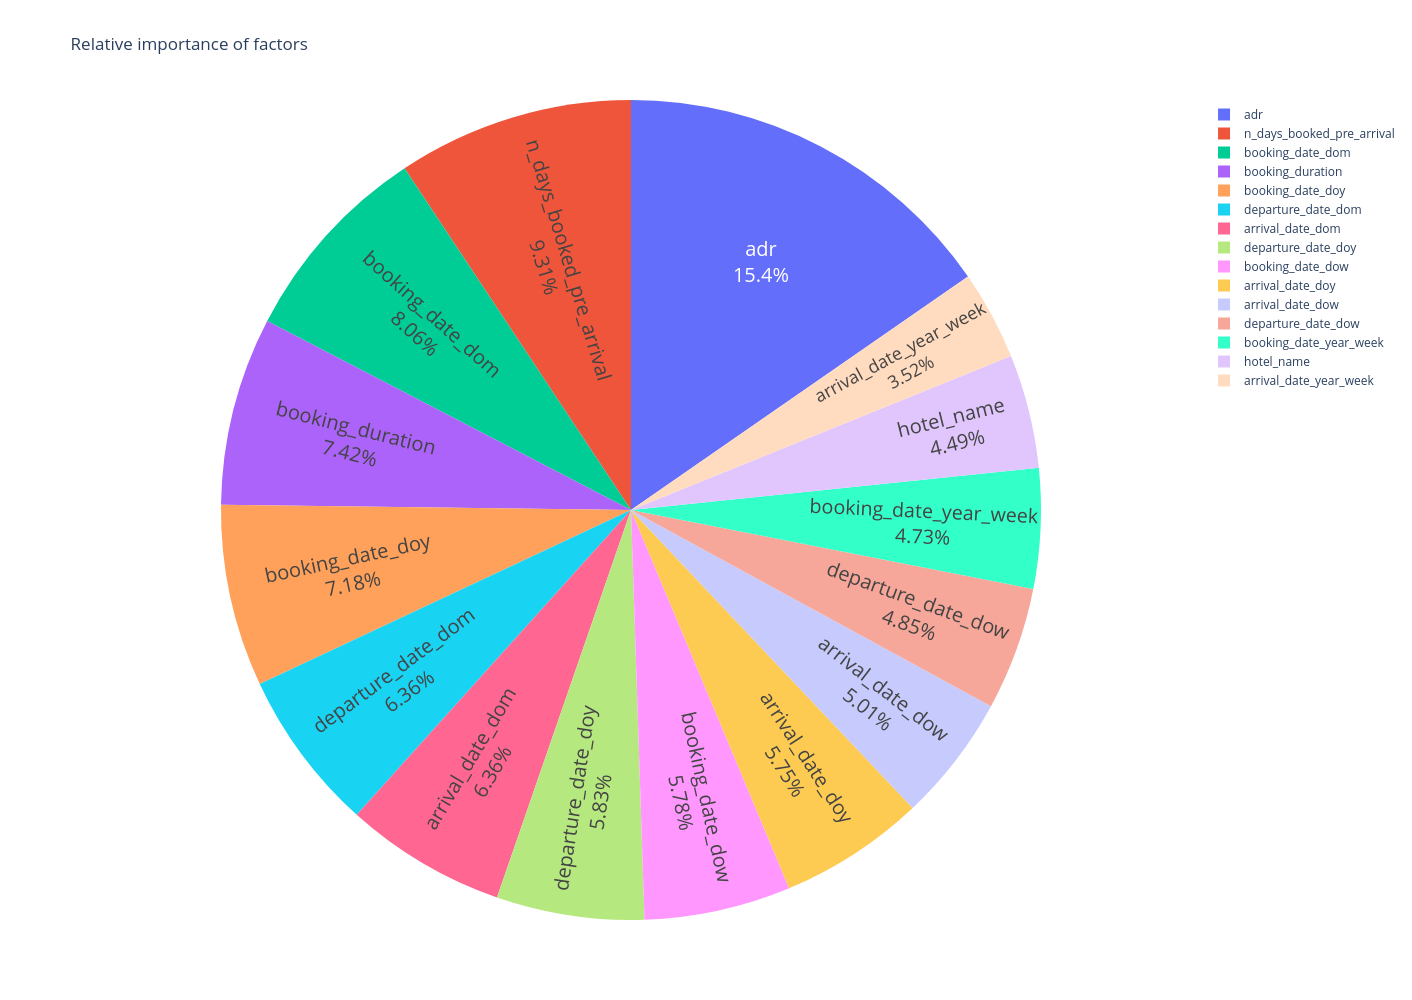

In [32]:
fig = px.pie(
    df_imp.head(15), 
    values='importance',
    names='feature',
    labels='feature',
    hover_data=['importance'],
    title='Relative importance of factors',
    width=1000, 
    height=1000
)
fig.update_traces(textposition='inside', textinfo='label+percent', textfont_size=20)
fig.show()

Let's repeat the same exercise but for top 10 and last 10 countries (from the last section) only

In [33]:
df_ = df_l3.merge(pd.concat((df_country_stats_filtered.head(10), df_country_stats_filtered.tail(10)))['source_country'], on='source_country', how='inner')

for col in cat_cols:
    df_[col] = LabelEncoder().fit_transform(df_[col])

In [34]:
mdl = DecisionTreeClassifier(random_state=RND)
mdl.fit(df_[input_cols], df_['source_country'])

DecisionTreeClassifier(random_state=42)

In [35]:
df_imp = pd.DataFrame({"feature": input_cols, "importance": mdl.feature_importances_}).sort_values('importance', ascending=False)

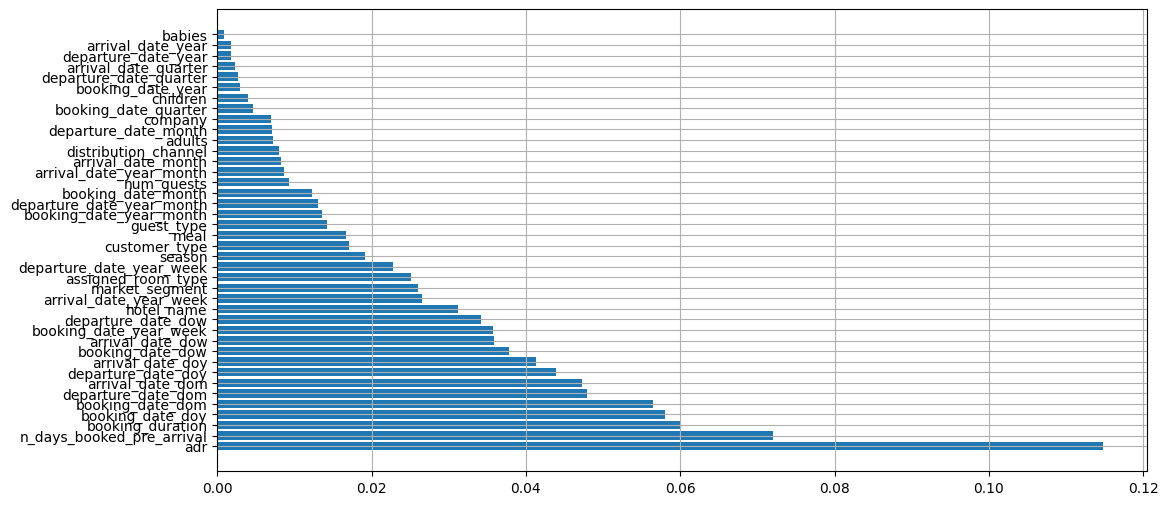

In [36]:
plt.figure(figsize=(12, 6))
plt.barh(df_imp['feature'], width=df_imp['importance'])
plt.grid(True)

From the above chart it could be concluded, with some good confidence, that the prices (denoted by `adr`) are highly distinguishable between guests coming from different countries followed by how many days in advance the booking has been made and duration of stay (i.e. `booking_duration`). 

This could also be aligned with our general understanding in the following directions:
1. That not all countries enjoy the same economic conditions like the top 5 countries - this has a major influence in the spending on luxury decision per capita.
2. Since this data is from a hotel chain which operates in EU it is quite likely that European guests are the only ones who can afford planning a travel just a few days in advance which is not possible for people living in remote parts of the world also due to legal, immigration & time-of-travel related reasons.
3. Therefore, usually the people coming from outside EU would book quite some days in advance and also spend more number of days - this could potentially influence the `adr`.

## Conduct a few A/B tests

In this section we try to conduct a few tests on a some pairs of variables to assess the influence of one over the other. We are interested in the following pairs:
1. `is_canceled` and `n_days_pre_arrival`
2. `is_canceled` and `adr`

In [37]:
df_l3_ = df_l2.loc[df_l2['is_canceled']].reset_index(drop=True).copy()

### `is_canceled` vs `n_days_pre_arrival`

Our null hypothesis here is - there is no effect of cancellations on how many days in advance the booking has been made.

Text(0.5, 1.0, 'p-value: 0.4972')

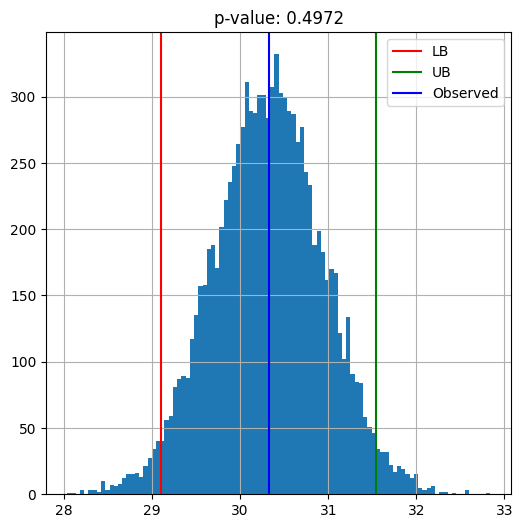

In [38]:
n_bootstrap = 10000
boot_means_A = []
boot_means_B = []

for _ in range(n_bootstrap):
    bootstrap_A = np.random.choice(df_l3['n_days_booked_pre_arrival'], size=len(df_l3), replace=True)
    bootstrap_B = np.random.choice(df_l3_['n_days_booked_pre_arrival'], size=len(df_l3_), replace=True)
    
    boot_means_A.append(bootstrap_A.mean())
    boot_means_B.append(bootstrap_B.mean())

mean_diff = np.mean(boot_means_B) - np.mean(boot_means_A)
boot_diff = np.array(boot_means_B) - np.array(boot_means_A)
conf_int = np.percentile(boot_diff, [2.5, 97.5])
p_value = np.mean(mean_diff > boot_diff)

plt.figure(figsize=(6,6))
plt.hist(np.array(boot_means_B) - np.array(boot_means_A), bins=100)
plt.axvline(x = conf_int[0], label='LB', color='red')
plt.axvline(x = conf_int[1], label='UB', color='green')
plt.axvline(x = mean_diff, label='Observed', color='blue')
plt.legend()
plt.grid(True)
plt.title(f"p-value: {p_value}")

So we fail to reject our null hypothesis and conclude that there is no significant impact of number of days booking done prior to travel on cancellations.

### `is_canceled` vs `adr`

Text(0.5, 1.0, 'p-value: 0.5005')

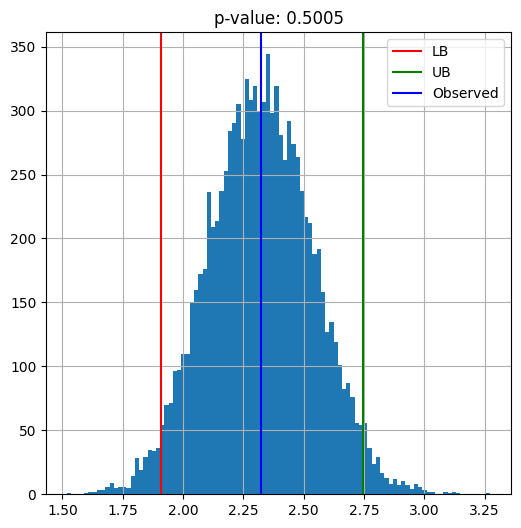

In [39]:
n_bootstrap = 10000
boot_means_A = []
boot_means_B = []

for _ in range(n_bootstrap):
    bootstrap_A = np.random.choice(df_l3['adr'], size=len(df_l3), replace=True)
    bootstrap_B = np.random.choice(df_l3_['adr'], size=len(df_l3_), replace=True)
    
    boot_means_A.append(bootstrap_A.mean())
    boot_means_B.append(bootstrap_B.mean())

mean_diff = np.mean(boot_means_B) - np.mean(boot_means_A)
boot_diff = np.array(boot_means_B) - np.array(boot_means_A)
conf_int = np.percentile(boot_diff, [2.5, 97.5])
p_value = np.mean(mean_diff > boot_diff)

plt.figure(figsize=(6,6))
plt.hist(np.array(boot_means_B) - np.array(boot_means_A), bins=100)
plt.axvline(x = conf_int[0], label='LB', color='red')
plt.axvline(x = conf_int[1], label='UB', color='green')
plt.axvline(x = mean_diff, label='Observed', color='blue')
plt.legend()
plt.grid(True)
plt.title(f"p-value: {p_value}")

Atleast from the AB tests above it cannot be concluded with high confidence that cancellations are affected by prices or how many days in advance the bookings were made.

## How do prices measured by the average daily rate (`adr`) differ across hotels and time?

For this section we could utilize a normal plot for each of the 5 hotels in our dataset. Let's start by looking at the daily trends.

### Daily trends

/tmp/ipykernel_13069/1309551515.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



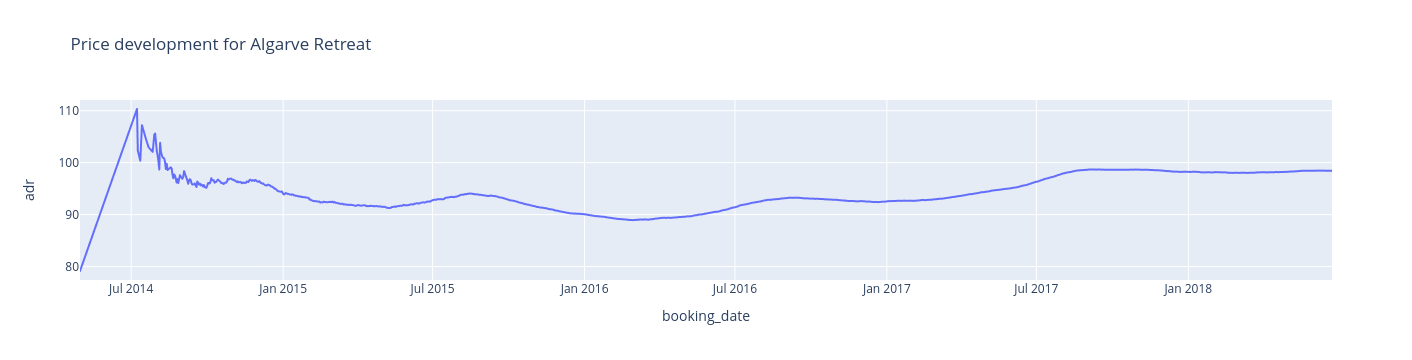

/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



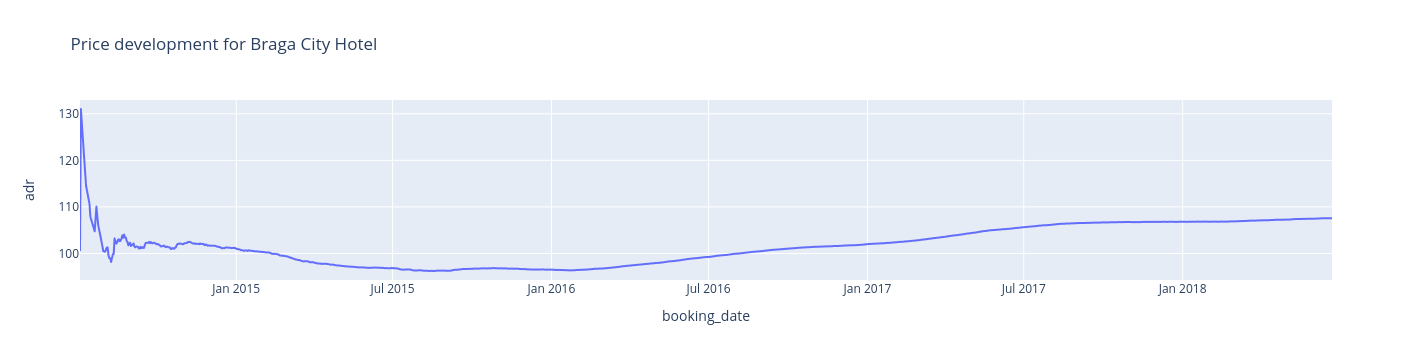

/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



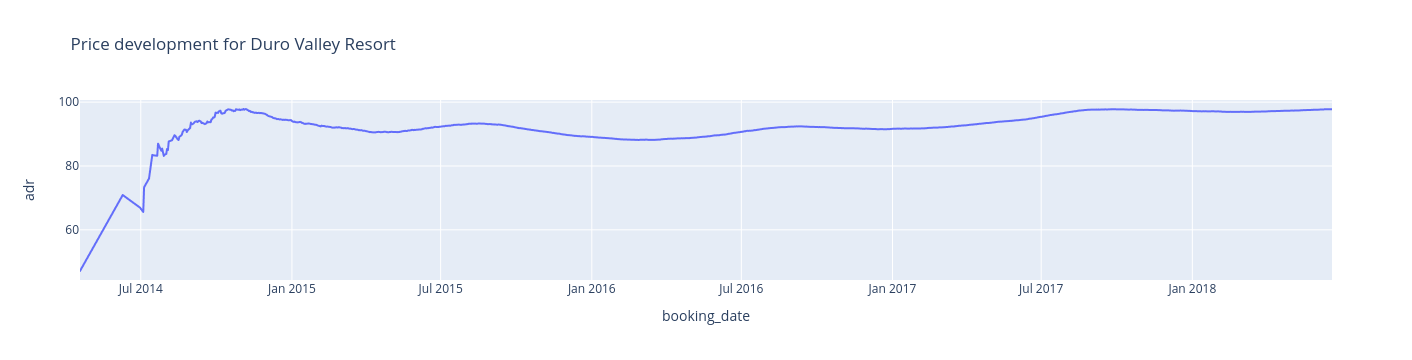

/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



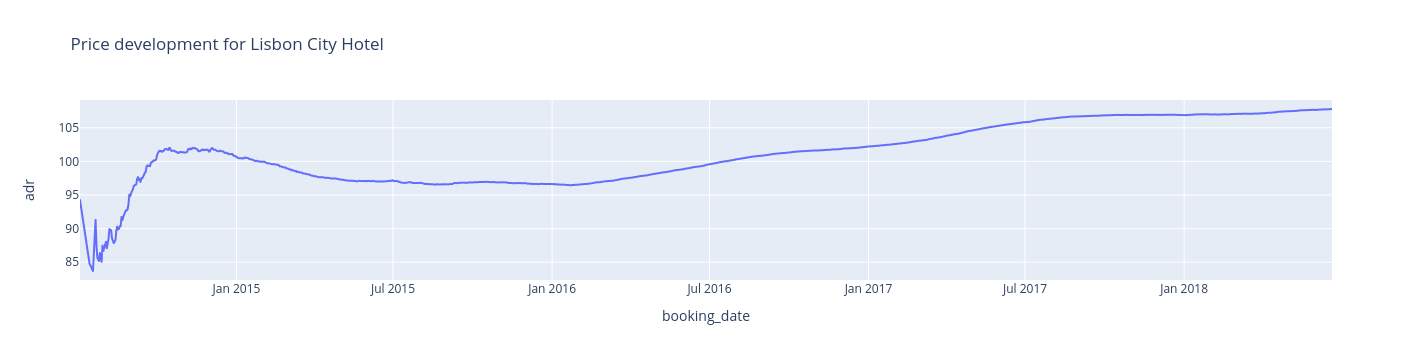

/home/kappa/Documents/code/non_git/tui_task/venv/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



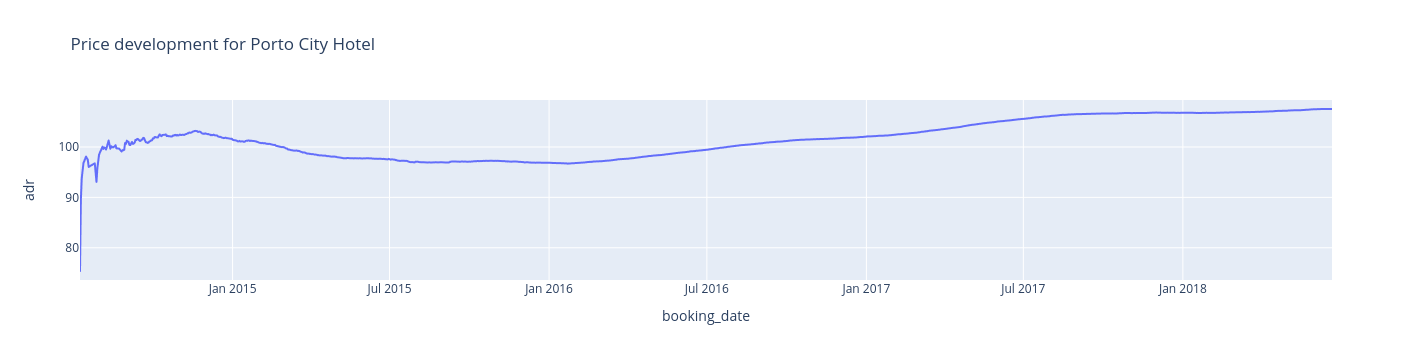

In [32]:
for hotel, gdf in df_l2.groupby("hotel_name"):
    df_sorted = gdf.sort_values("booking_date")
    df_sorted = df_sorted.groupby('booking_date')['adr'].mean()
    # df_sorted = df_sorted.rolling('7D').mean() # switch on for rolling
    # df_sorted = df_sorted.to_frame().expanding(min_periods=1).mean() # switch on for expanding
    fig = px.line(
        df_sorted.reset_index(), 
        x='booking_date', 
        y="adr",
        title=f"Price development for {hotel}"
    )
    fig.show()

We can see that the daily developments are very noisy. Let's average them on a weekly basis and check again.

### Weekly trends

Here we also try and observe the trends of each hotel for each room type

/tmp/ipykernel_78064/958764605.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



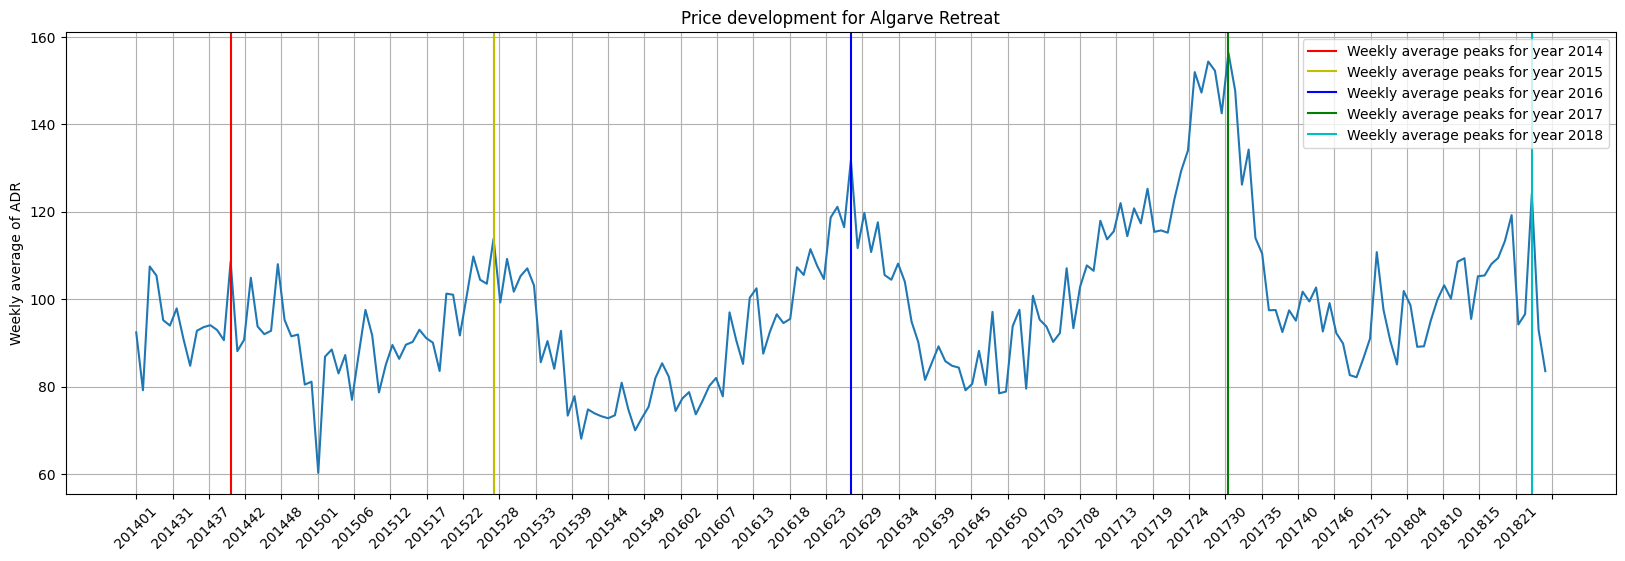

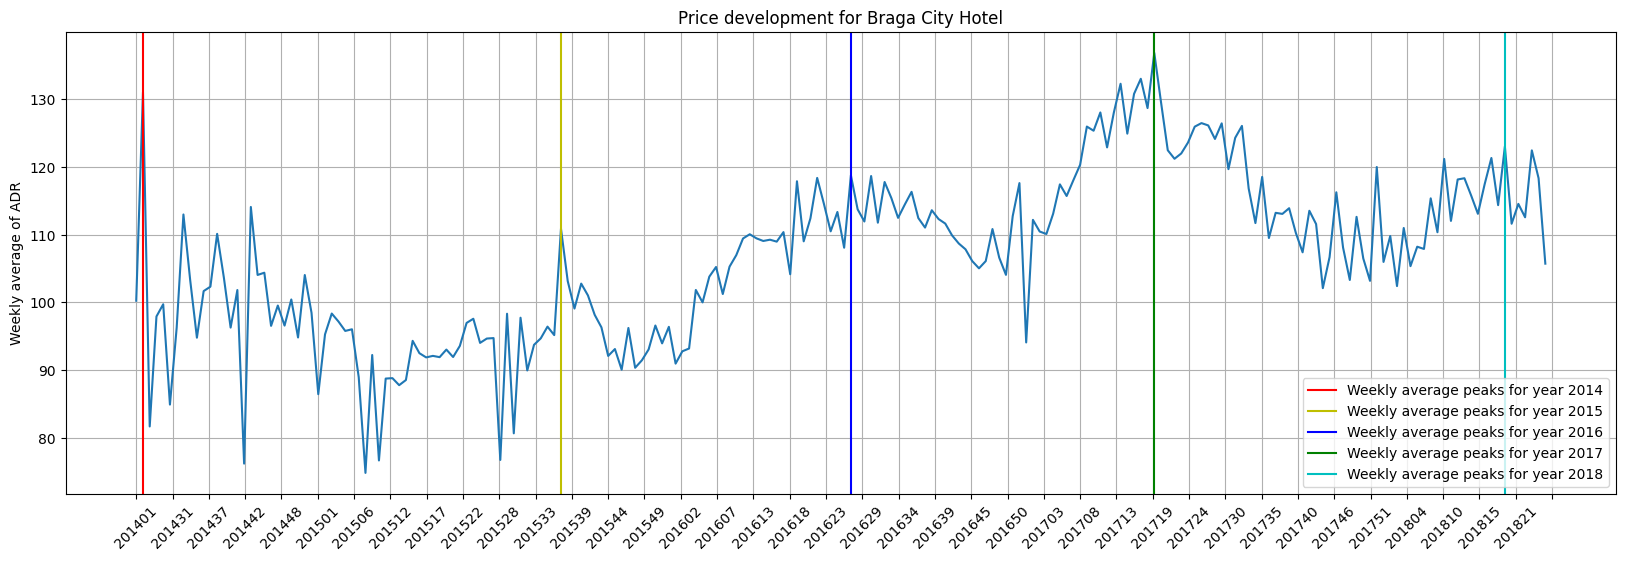

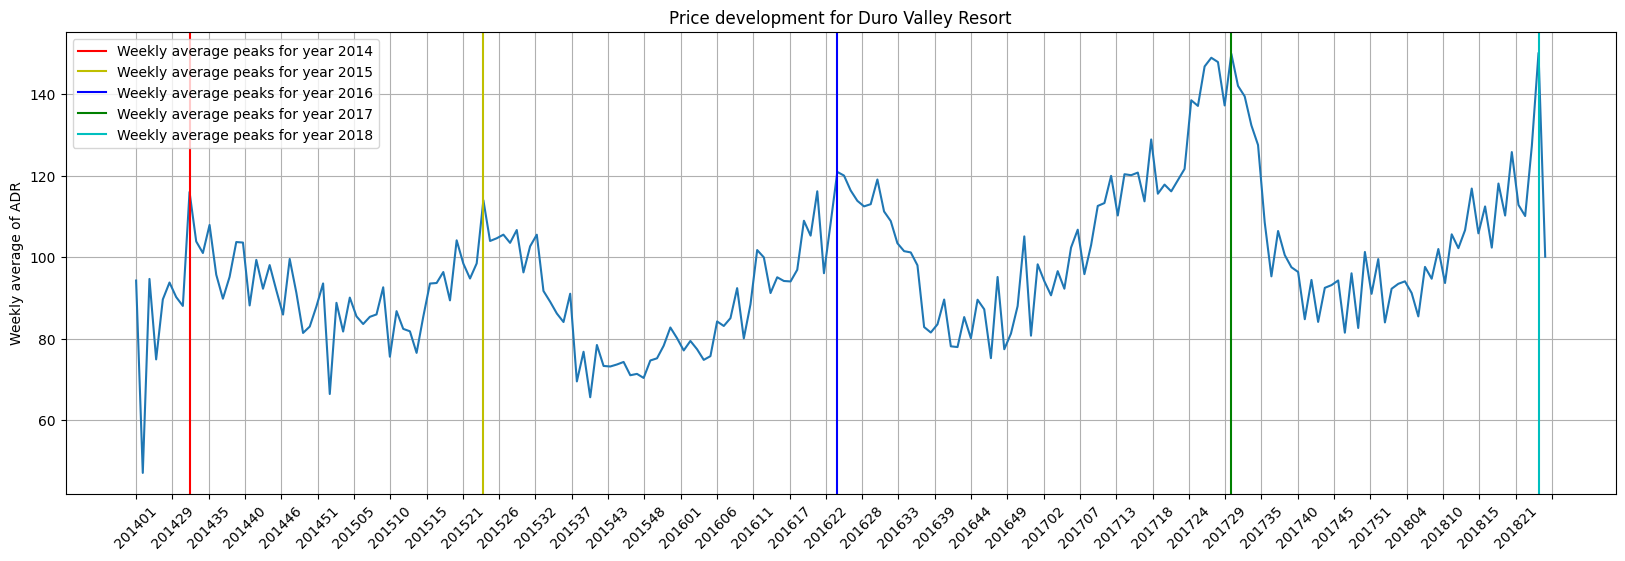

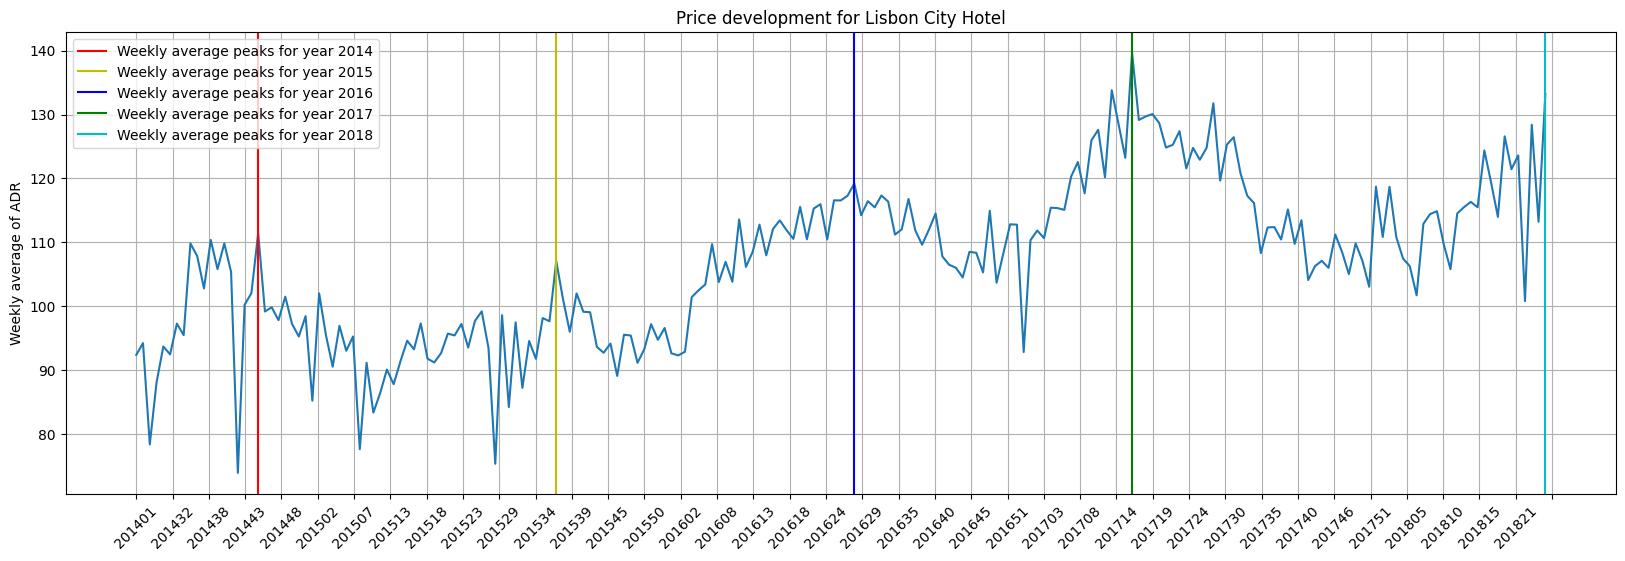

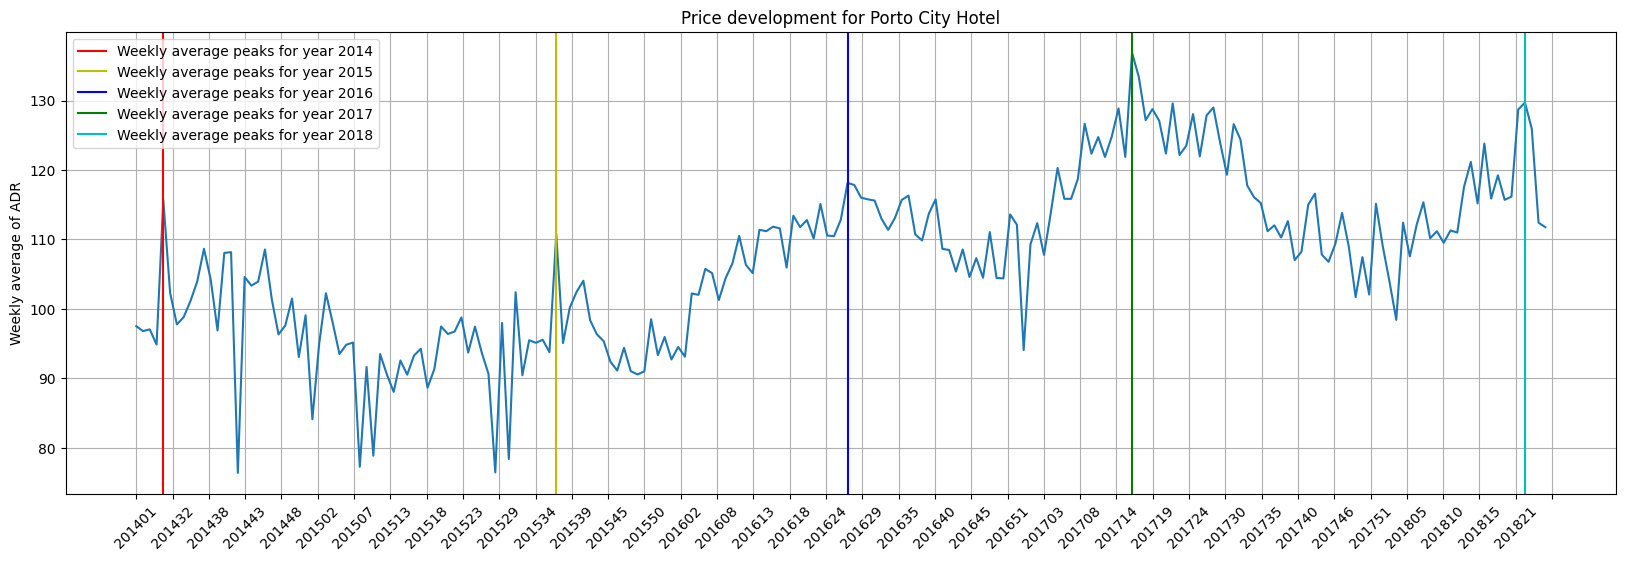

In [41]:
for hotel, gdf in df_l2.groupby("hotel_name"):
    df_averaged = gdf.groupby(['booking_date_year', 'booking_date_year_week'], as_index=False).agg({'adr': 'mean'})
    df_sorted = df_averaged.sort_values(['booking_date_year_week'], ascending=True)
    df_sorted["booking_date_year_week"] = df_sorted["booking_date_year_week"].astype(str) # this is done just for a visual enahanecment
    fig = plt.figure(figsize=[20,6])
    plt.plot(
        df_sorted['booking_date_year_week'],
        df_sorted['adr']
    )
    plt.title(f"Price development for {hotel}")
    plt.xticks(np.linspace(0, len(df_sorted['booking_date_year_week']), 40), rotation=45)
    plt.grid(True)
    # calculate weeks where it peaked for every year
    # max_weeks = []
    colors = ['r', 'y', 'b', 'g', 'c']
    for i, (year, gdf2) in enumerate(df_sorted.groupby("booking_date_year")):
        weeks_nr = gdf2.set_index('booking_date_year_week')['adr'].idxmax()
        plt.axvline(x = str(weeks_nr), label=f'Weekly average peaks for year {year}', color=colors[i])
    plt.ylabel("Weekly average of ADR")
    plt.legend()

The weekly trends look a bit more interpretable. Following are a few observations:
1. In general there is a slight increasing trend - we could further conduct a ADF test to confirm if there is indeed a significant increase or not.
2. There is somewhat a cyclic behaviour - i.e. the prices go up during weeks - 25-35 these are near summer season (third quarter). However, this does not quite hold true for the years 2014 and 2015 because from the histogram plots (in the previous section) we could see that the number of bookings were very less in those years compared to the subsequent years.
3. For the year 2016 all hotels have highest rates around week 25.
4. For the year 2017:   
     * the "City" hotels have highest rates near the weeks 16 to 19.
     * the other two hotels "Algarve Retreat" and "Duro Valley Resort" have highest rates near week 30. Also there is a *sharp decline* in rates just after the max peaks around that time for these two hotels on contrary to the rates of the other three hotels where we can see a more stable decrease.

### Distribution per year-month per hotel

/tmp/ipykernel_78064/1277302530.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



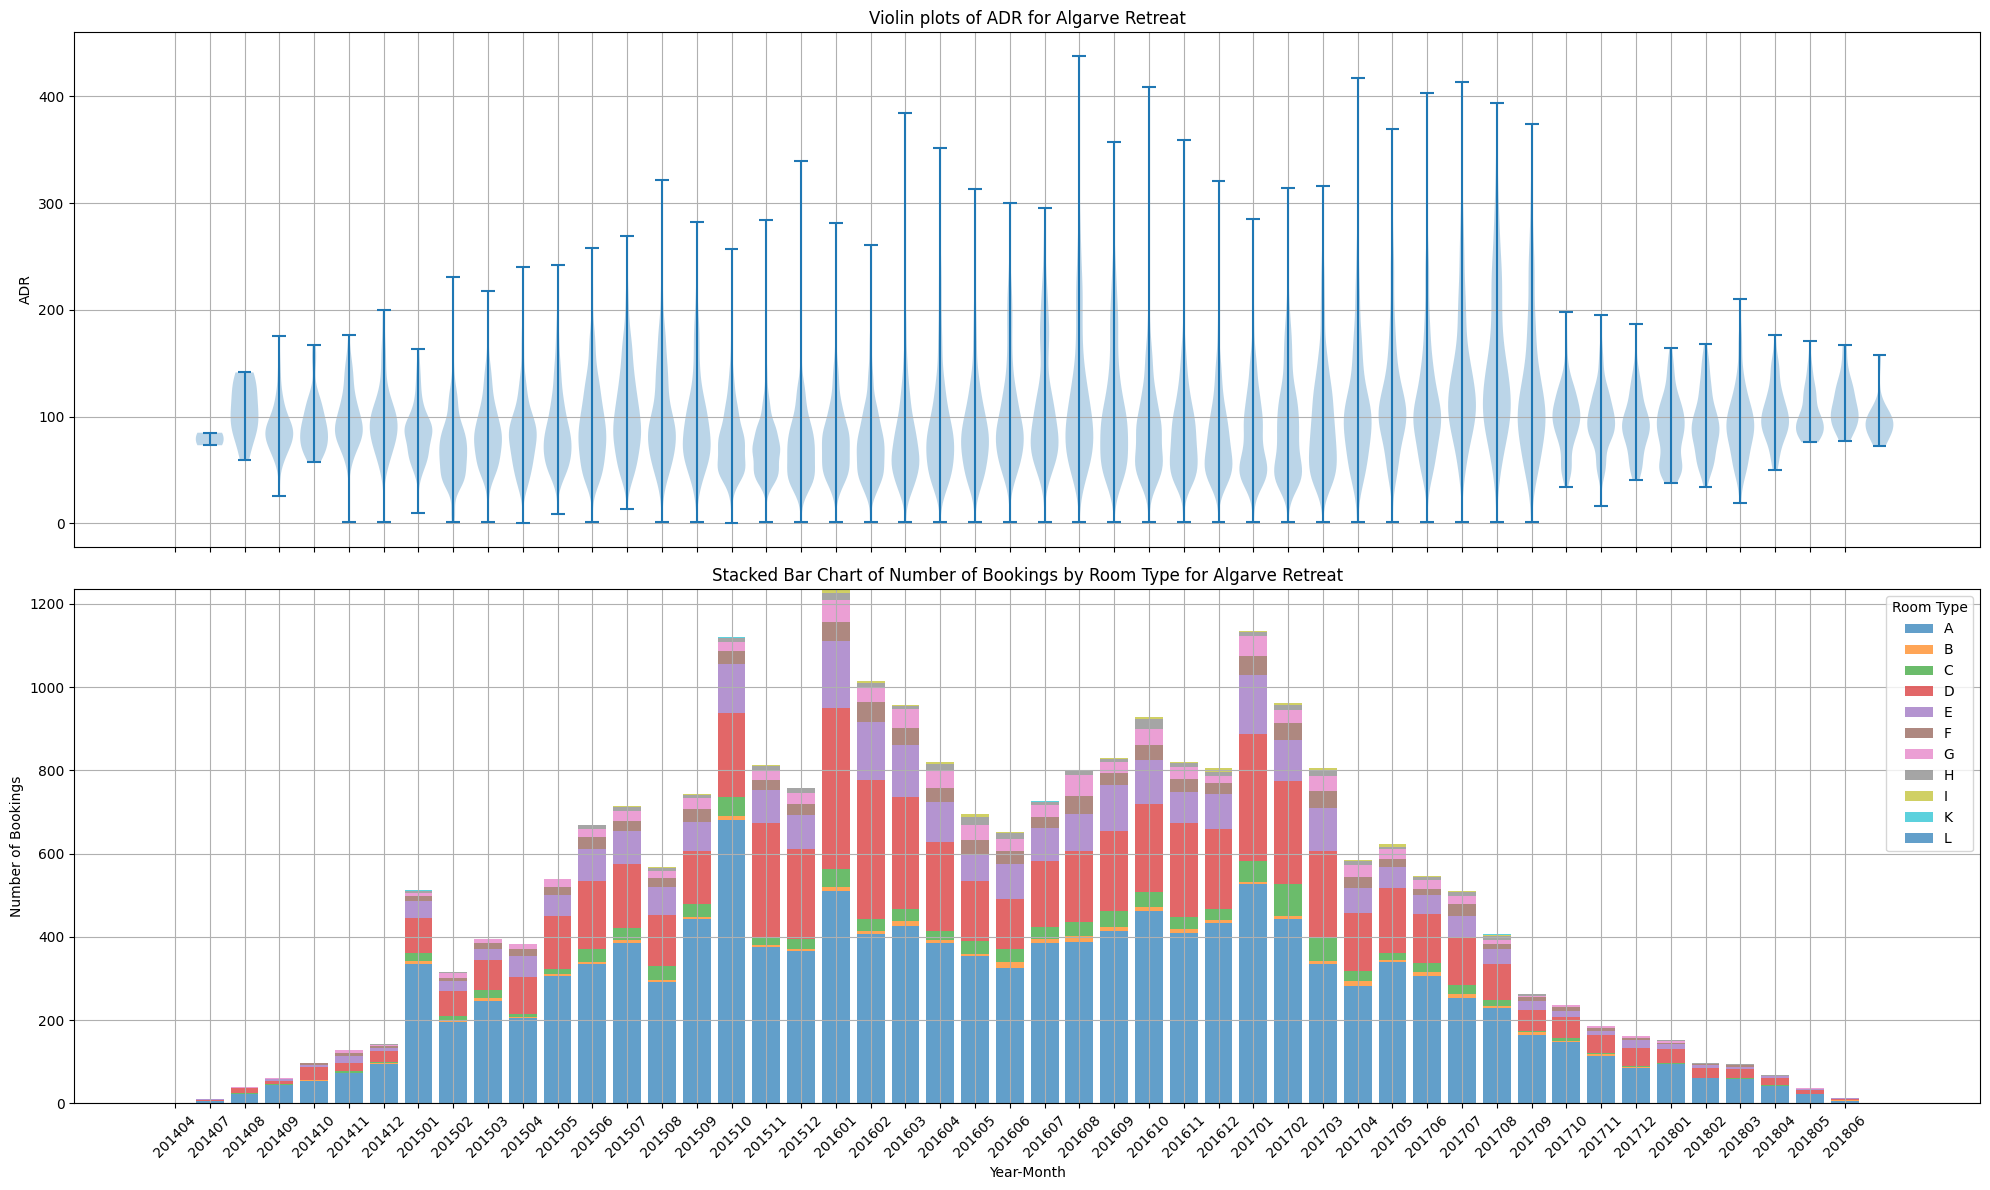

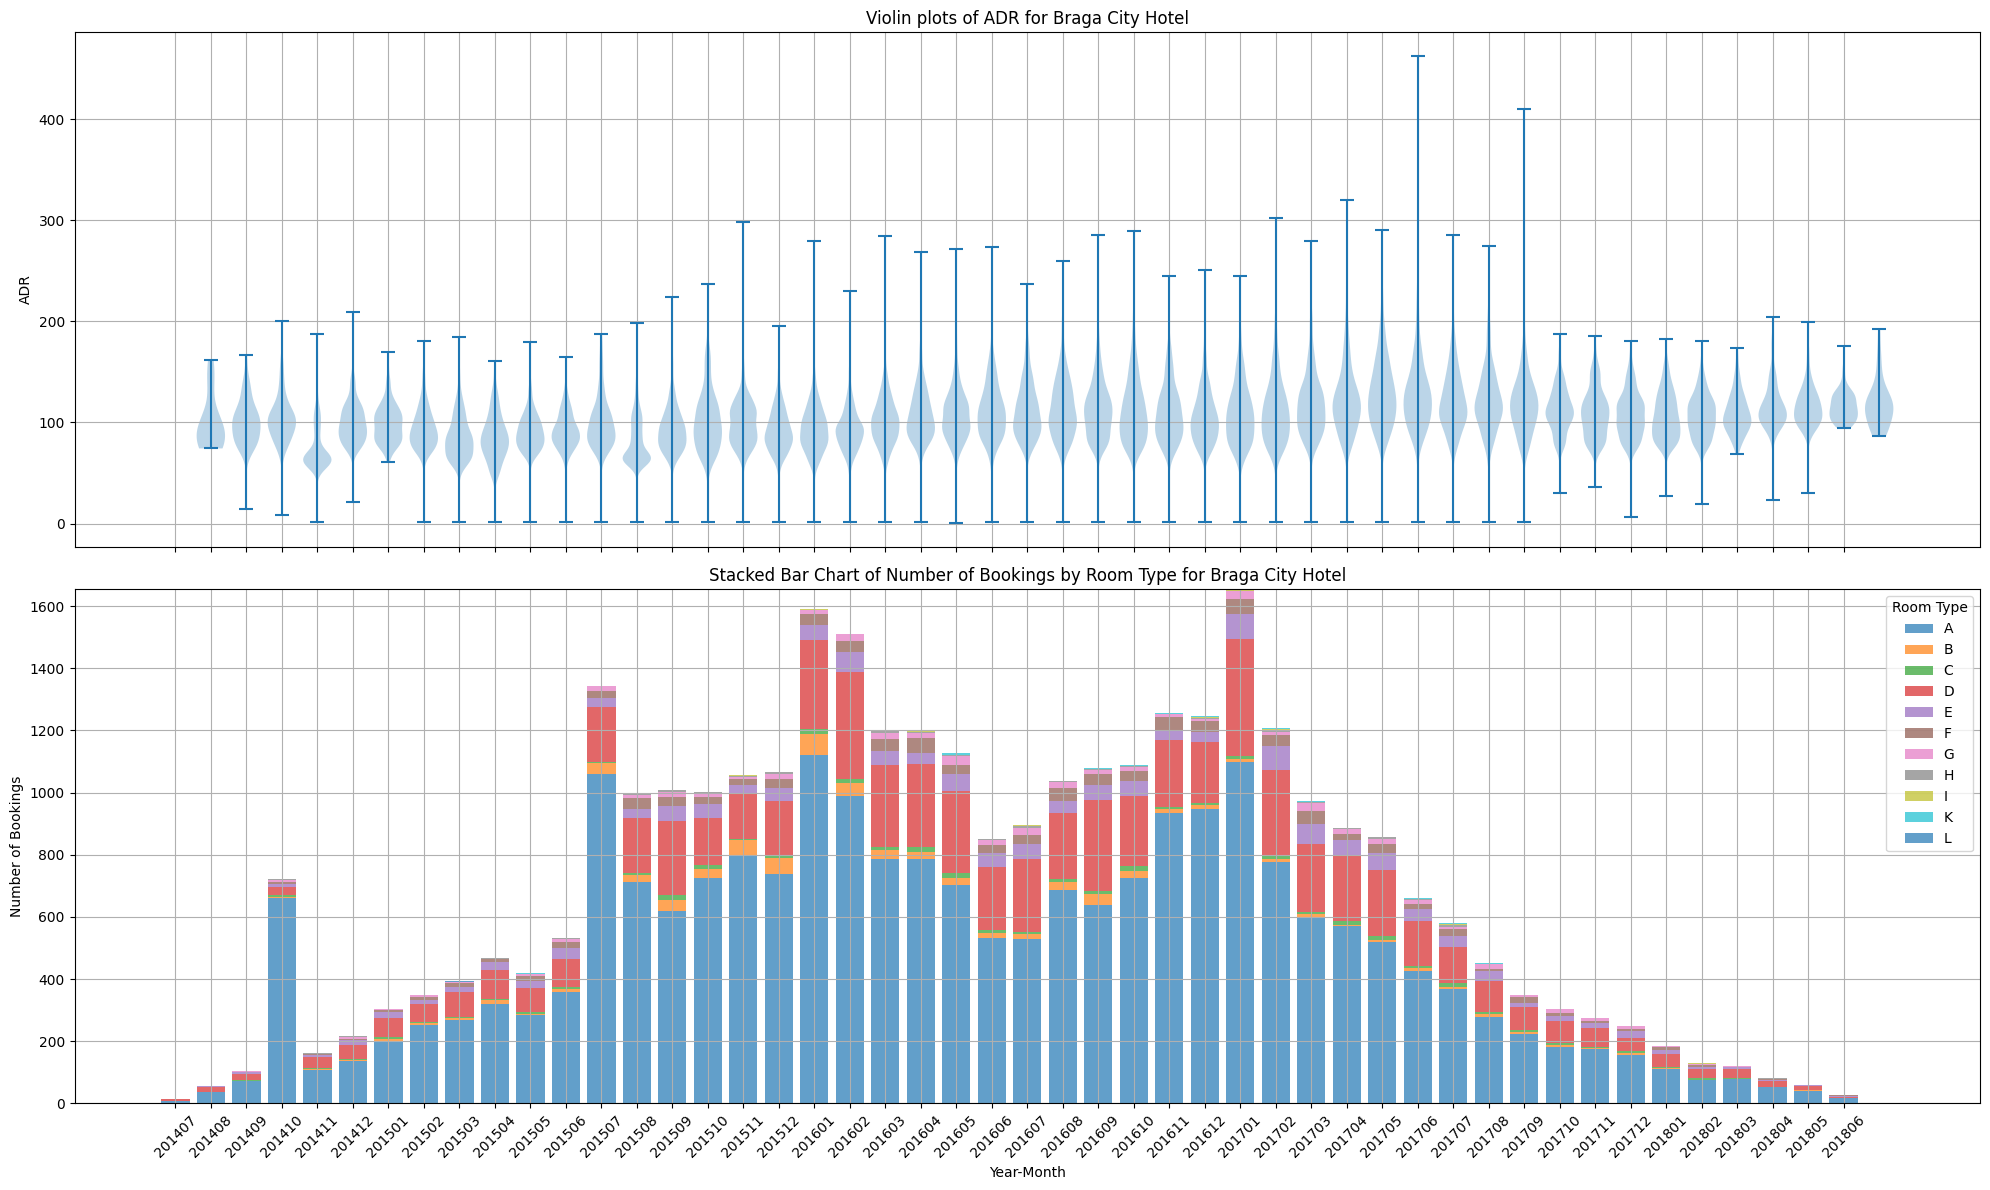

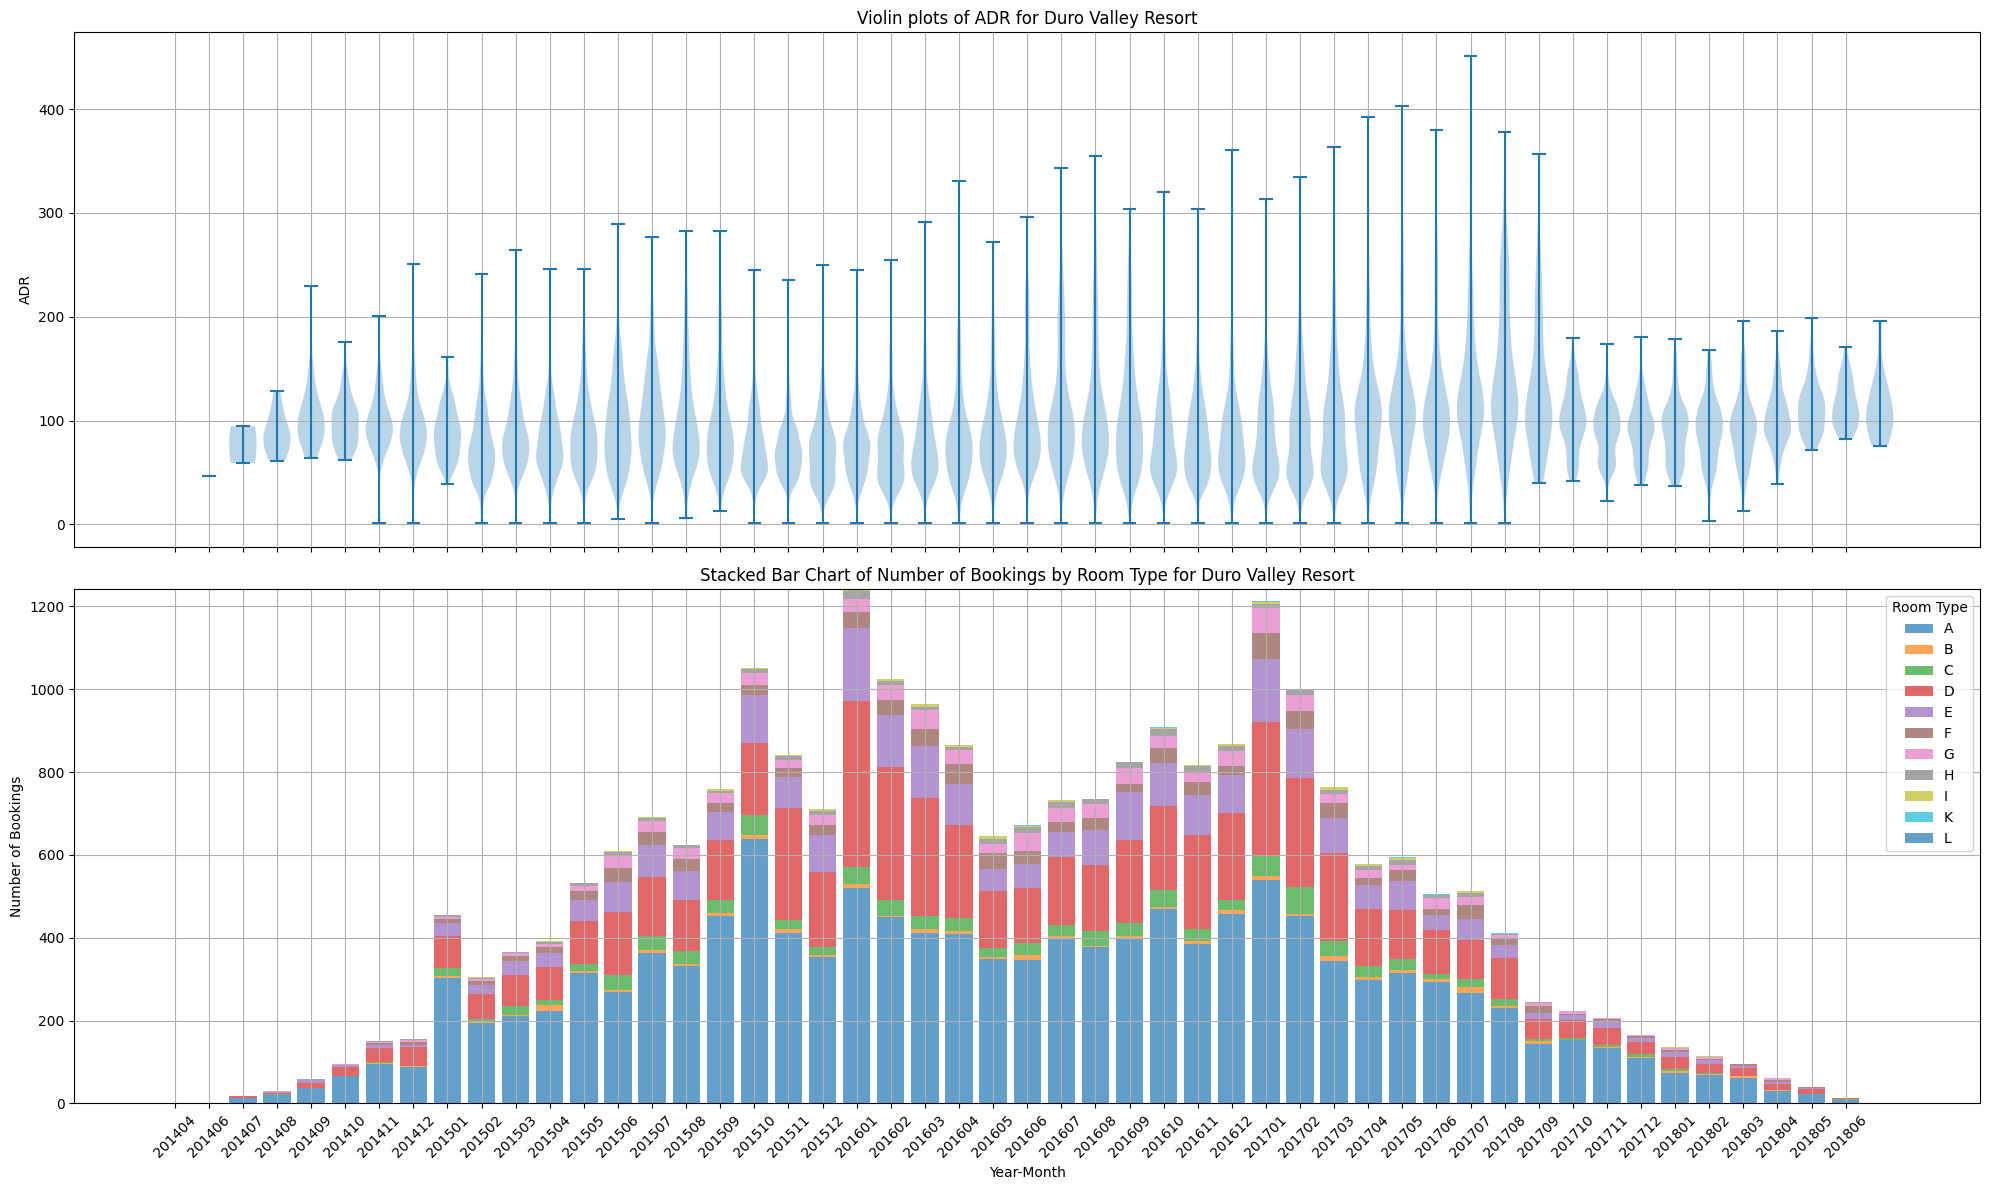

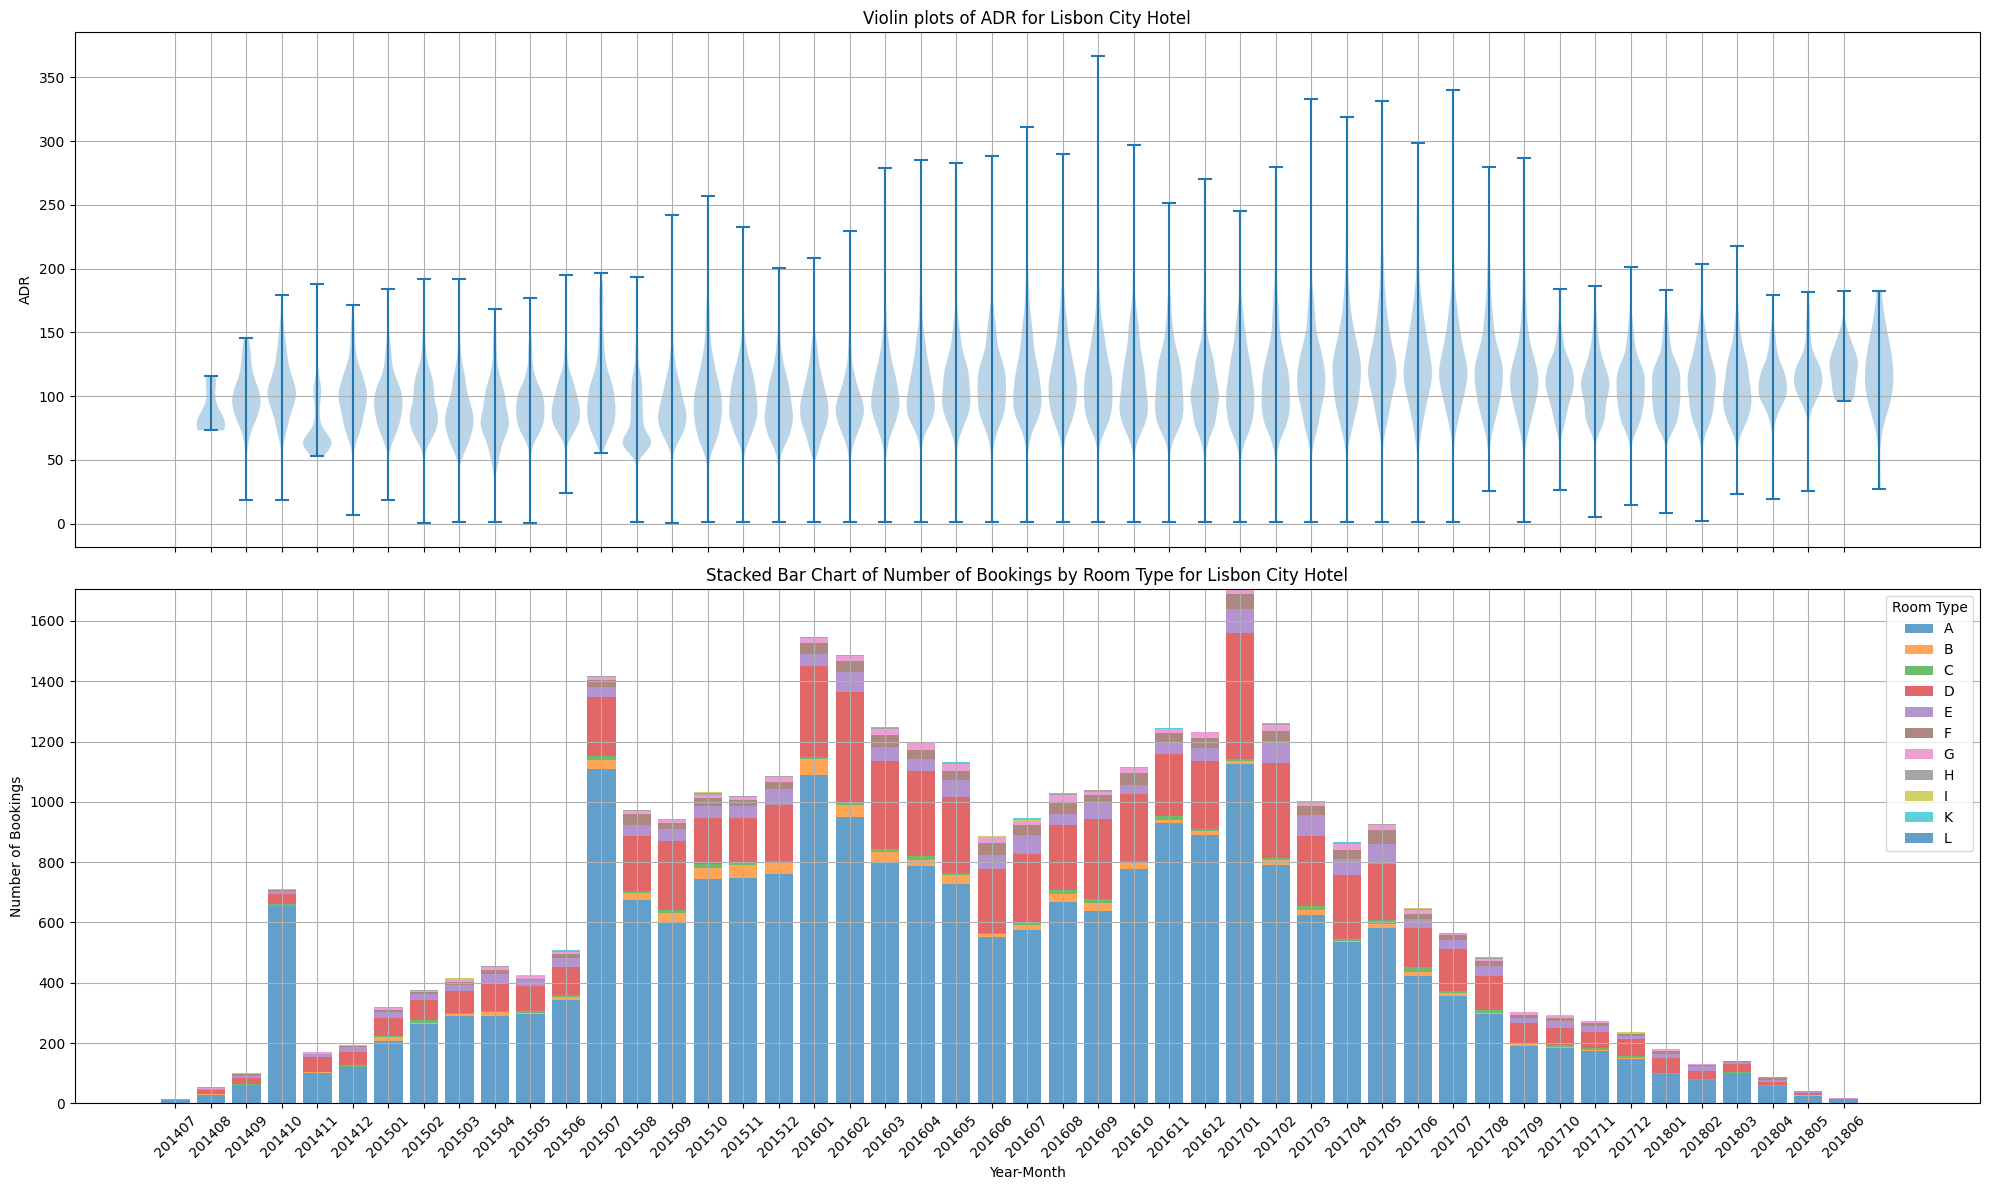

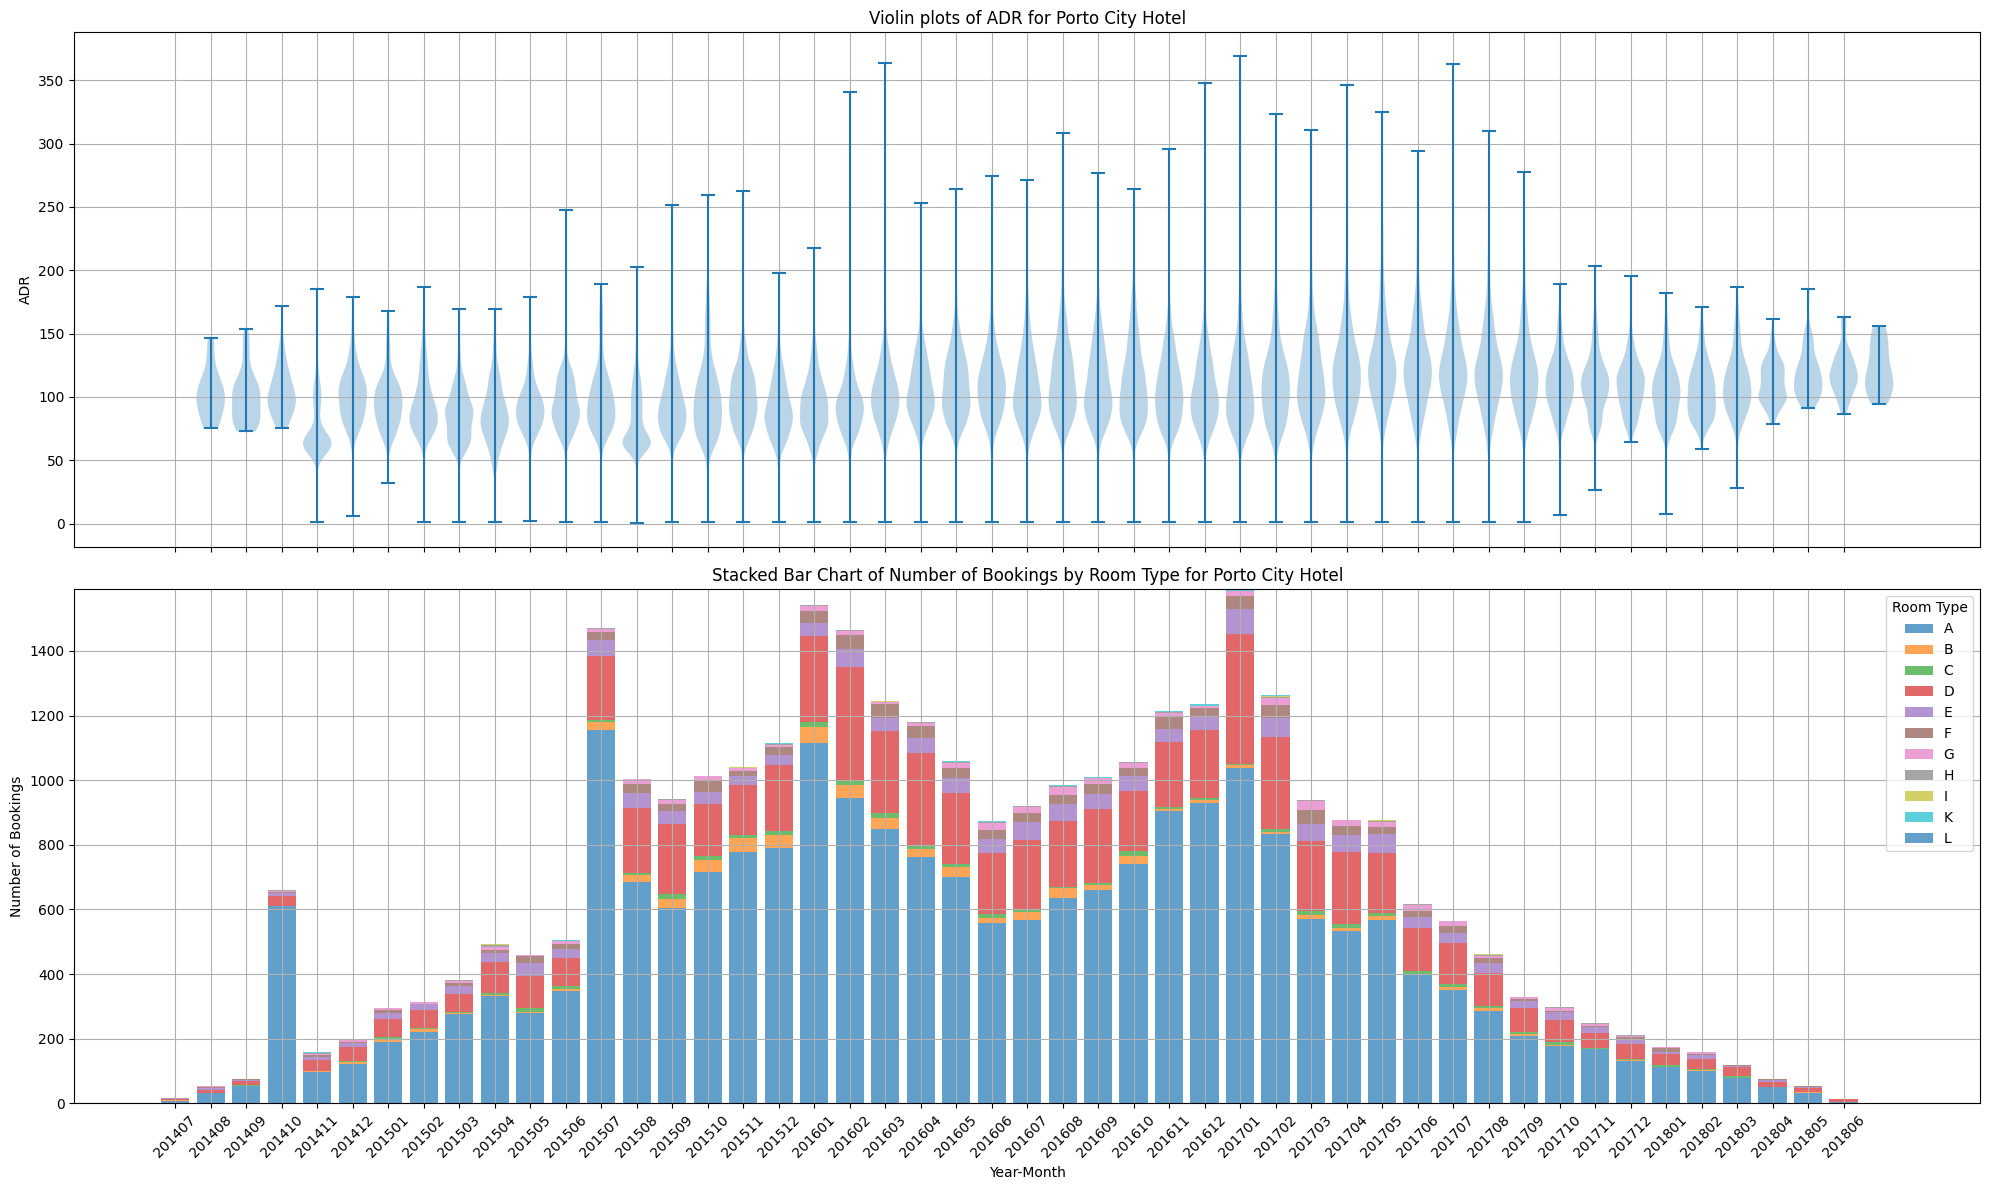

In [42]:
for hotel, gdf in df_l2.groupby('hotel_name'): # use `df_l3` to look at bookings that were not cancelled
    labels = []
    year_month_data = []
    booking_count_by_room_type = {}
    
    for ym, gdf2 in gdf.groupby('booking_date_year_month'):
        year_month_data.append(gdf2['adr'].to_numpy())
        room_type_counts = gdf2['assigned_room_type'].value_counts().to_dict()
        
        for room_type, count in room_type_counts.items():
            if room_type not in booking_count_by_room_type:
                booking_count_by_room_type[room_type] = []
            booking_count_by_room_type[room_type].append(count)
        
        labels.append(f"{ym}")
    booking_count_by_room_type = dict(sorted(booking_count_by_room_type.items()))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[20, 12], sharex=True)

    # Violin plot for ADR on the first subplot
    ax1.violinplot(year_month_data, widths=0.8)
    ax1.set_title(f"Violin plots of ADR for {hotel}")
    ax1.set_ylabel('ADR')
    ax1.grid(True)

    # Stacked bar plot for Number of Bookings by Room Type on the second subplot
    bottom_values = np.zeros(len(labels))
    for room_type, counts in booking_count_by_room_type.items():
        ax2.bar(range(len(labels)), counts, bottom=bottom_values, label=room_type, alpha=0.7)
        bottom_values += np.array(counts)

    ax2.set_title(f"Stacked Bar Chart of Number of Bookings by Room Type for {hotel}")
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, rotation=45)
    ax2.set_xlabel('Year-Month')
    ax2.set_ylabel('Number of Bookings')
    ax2.legend(title='Room Type')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

### Distribution per year-month-room-type

In [58]:
def plot_distbn_ym_room(room_type, df):
    df_ = df.loc[df['assigned_room_type'] == room_type]
    for hotel, gdf in df_.groupby('hotel_name'): # use `df_l3` to look at bookings that were not cancelled
        labels = []
        year_month_room_data = {}
        booking_count_by_room_type = {}
        
        for ym, gdf2 in gdf.groupby('booking_date_year_month'):
            room_type_counts = gdf2['assigned_room_type'].value_counts().to_dict()
            
            for room_type, count in room_type_counts.items():
                if room_type not in booking_count_by_room_type:
                    booking_count_by_room_type[room_type] = []
                booking_count_by_room_type[room_type].append(count)
            
            labels.append(f"{ym}")
    
        for (ym, room), gdf2 in gdf.groupby(['booking_date_year_month', 'assigned_room_type']):
            if room not in year_month_room_data:
                year_month_room_data[room] = []
            year_month_room_data[room].append(gdf2['adr'].to_numpy())
            
            
        booking_count_by_room_type = dict(sorted(booking_count_by_room_type.items()))
        fig, axes = plt.subplots(len(year_month_room_data)+1, 1, figsize=[20, 12], sharex=True)
    
        ax2 = axes[-1]
        for ax1, room in zip(axes[0:-1], year_month_room_data):
            # Violin plot for ADR on the first subplot
            ax1.violinplot(year_month_room_data[room], widths=0.8)
            ax1.set_title(f"Violin plots of ADR for {hotel} {room}")
            ax1.set_ylabel('ADR')
            ax1.grid(True)
    
        # Stacked bar plot for Number of Bookings by Room Type on the second subplot
        bottom_values = np.zeros(len(labels))
        for room_type, counts in booking_count_by_room_type.items():
            ax2.bar(range(len(labels)), counts, bottom=bottom_values, label=room_type, alpha=0.7)
            bottom_values += np.array(counts)
    
        ax2.set_title(f"Stacked Bar Chart of Number of Bookings by Room Type for {hotel}")
        ax2.set_xticks(range(len(labels)))
        ax2.set_xticklabels(labels, rotation=45)
        ax2.set_xlabel('Year-Month')
        ax2.set_ylabel('Number of Bookings')
        ax2.legend(title='Room Type')
        ax2.grid(True)
    
        plt.tight_layout()
        plt.show()

In [64]:
# plot_distbn_ym_room('A', df_l2)

In [65]:
# plot_distbn_ym_room('D', df_l2)

In [66]:
# plot_distbn_ym_room('E', df_l2)

### Observations

The violin plots show a very interesting insight into the price variations for each month over the years. 

We can make the following observations:
1. In general, the prices _vary less_ for the "City" hotels than the other two.
2. For the non "City" hotels the prices do not quite follow a "normal" distribution - for some year-months they have 2 weeks. This means that there are more than one equally popular prices for those months (e.g. 201702 for "Algarve Retreat")
3. The median `adr` for the "City" hotels are mostly > 100 across seasons while for the other two they only tend to cross 100 during the summer seasons i.e. in the 5,6,7 months of the year.

On the other hand, looking at the stacked bar plot we see that:
1. The number of bookings also have a cyclic trend from 201506 to 201706 for all the hotels.
2. On an average, for _almost_ every month, the "City" hotels get more bookings than the rest two.
3. For all the hotels `room_type` "A" and "D" are among the most popular for all year-months.
4. For the hotels - "Algarve Retreat" and "Duro Valley Resort" the third most popular is room type "E".
5. As also observed in the previous sections, most bookings are made in the first month of 2016 and 2017.

In general, there is a lack of data for the years 2014, 2015 and 2018 probably because they have been pruned manually.

## More distribution of prices

Here we look at the above picture but from the perspective of `room_type`

/tmp/ipykernel_78064/1174262793.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



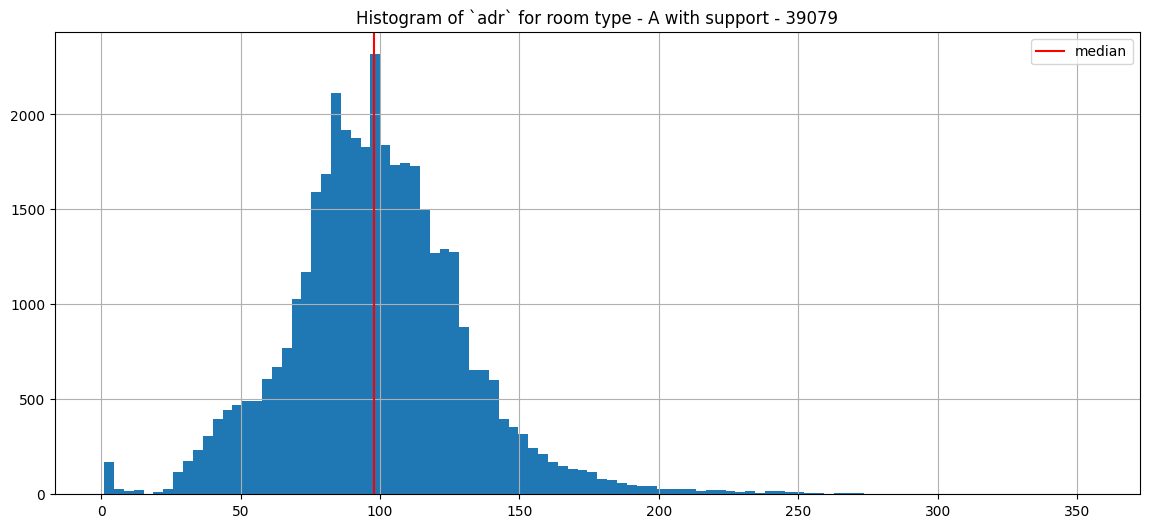

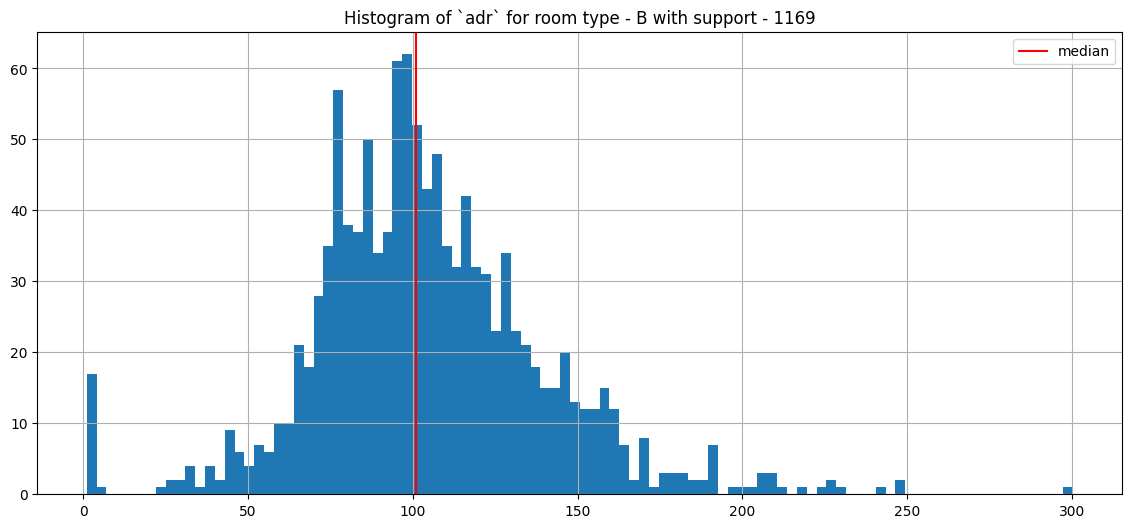

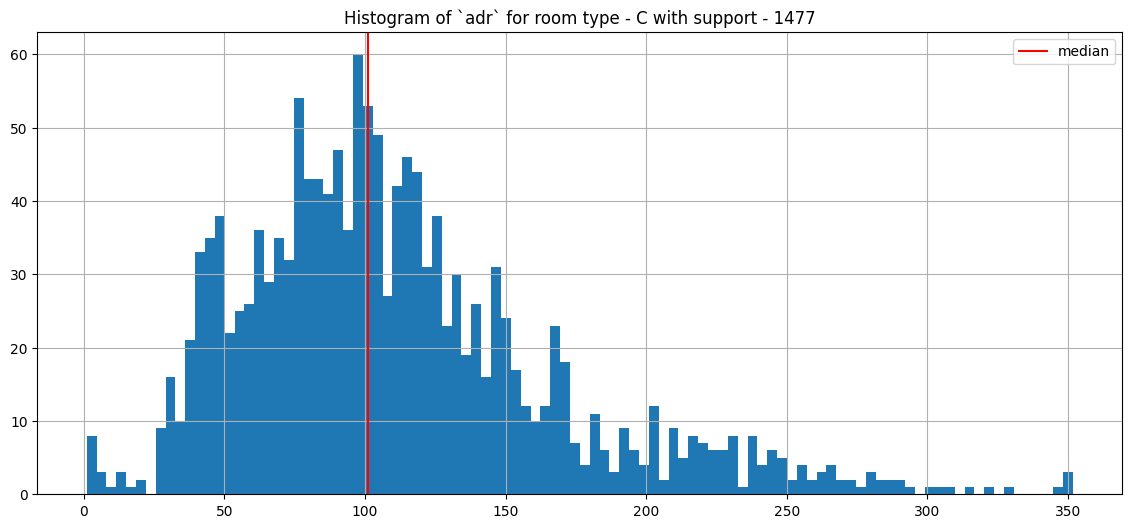

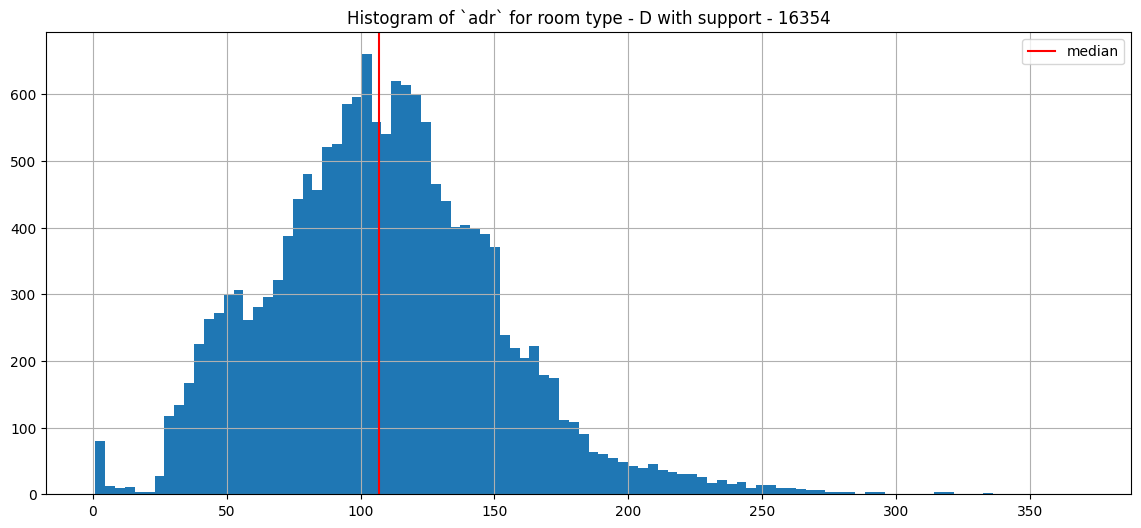

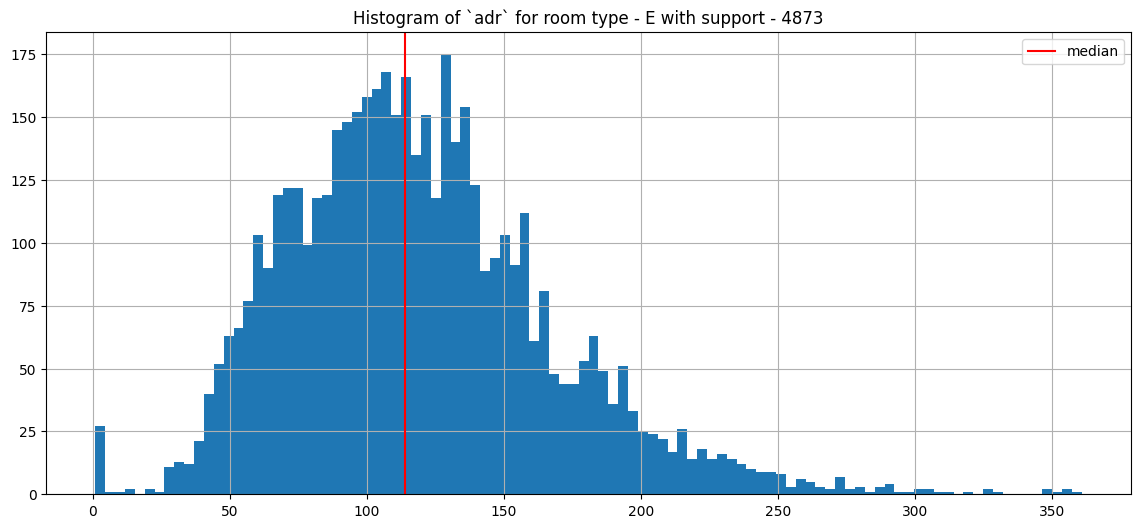

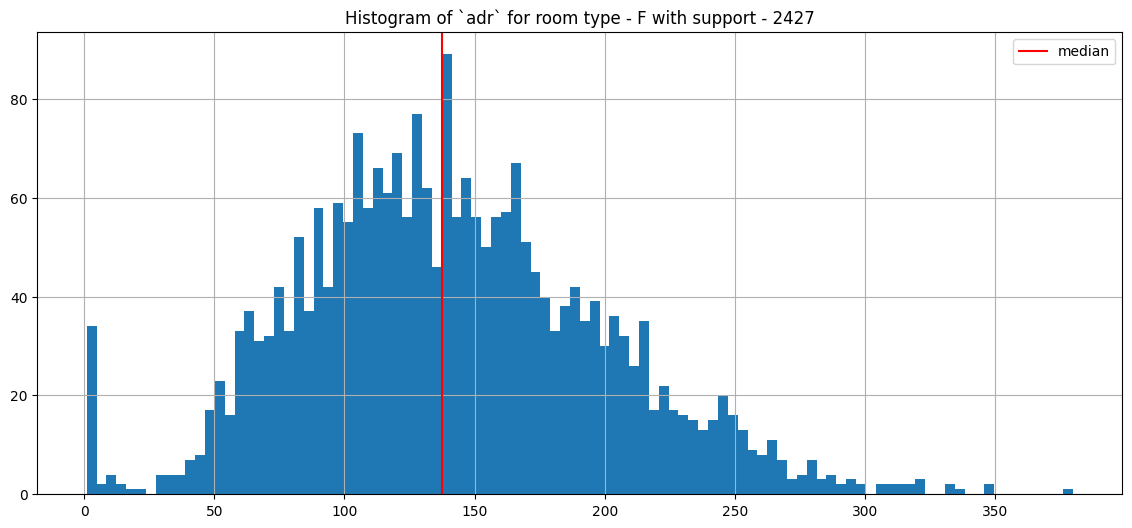

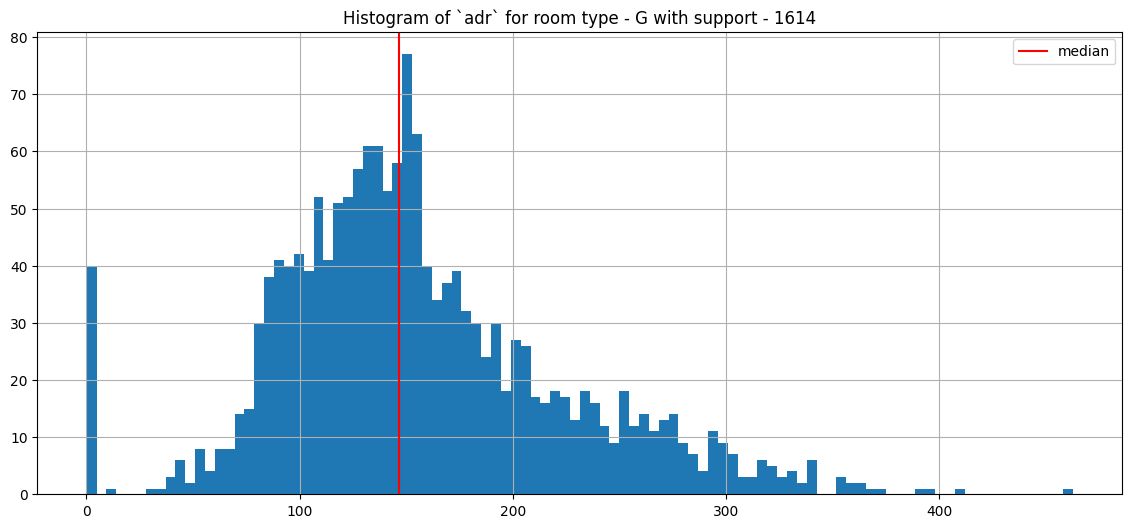

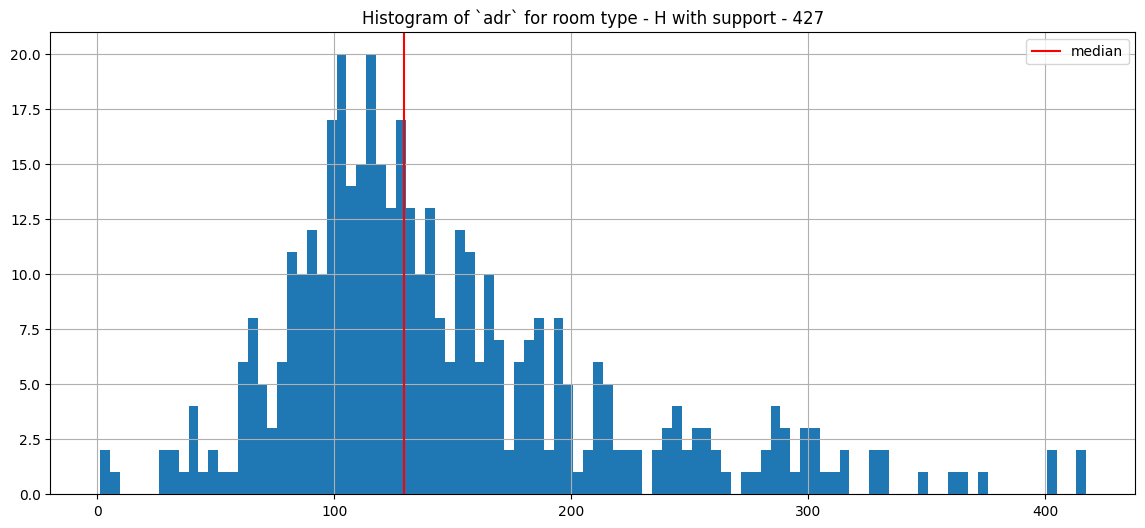

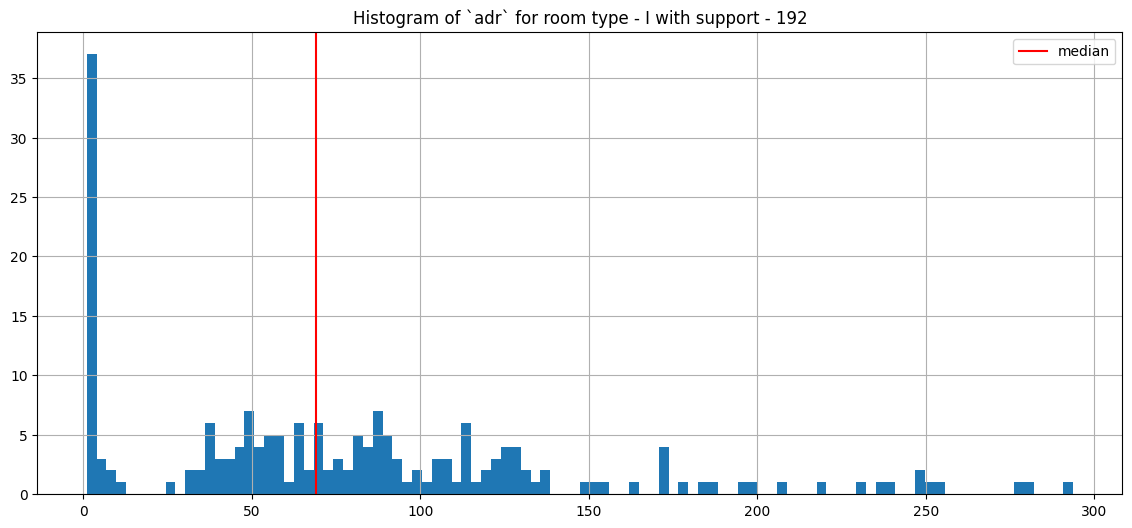

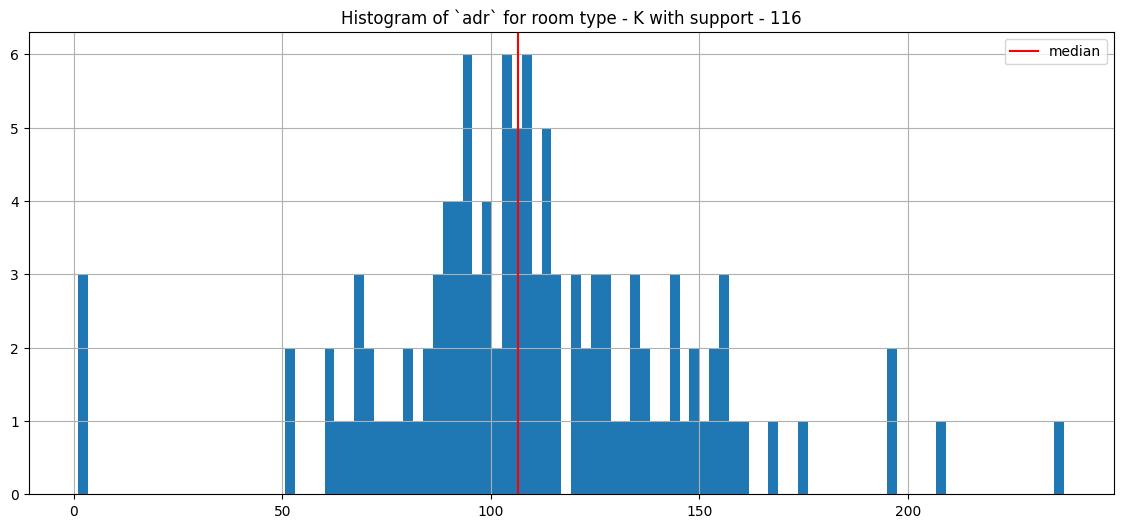

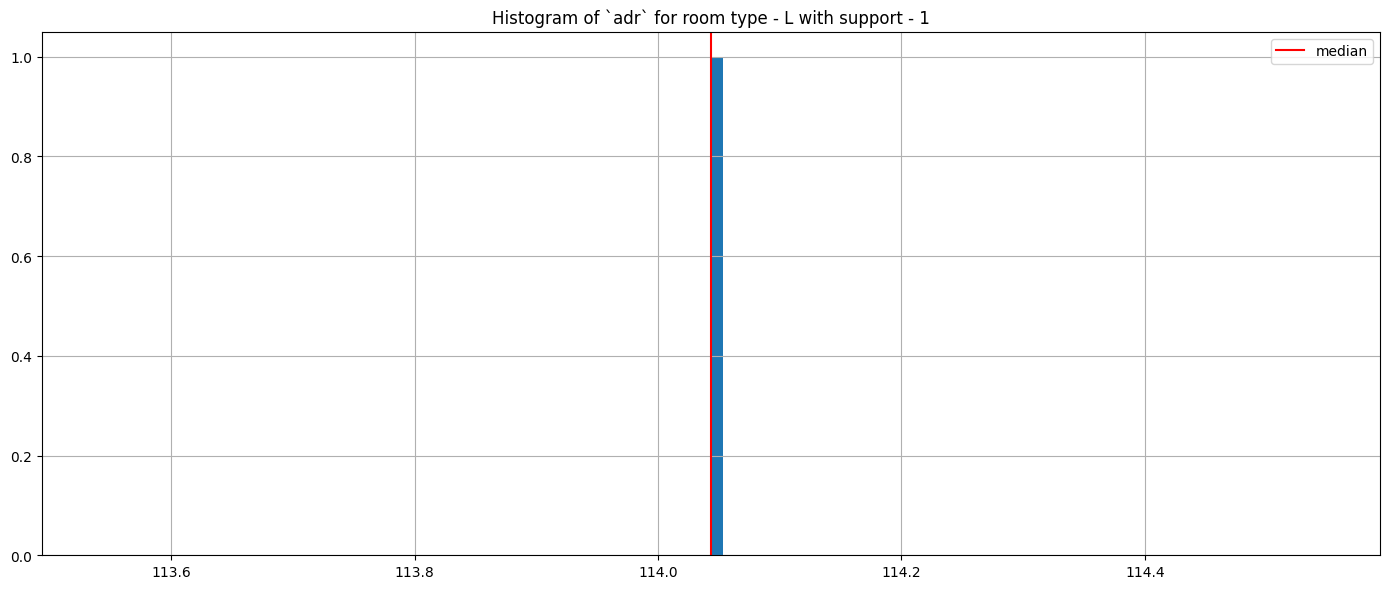

In [75]:
# only select the data for 2016 and 2017 and for the not cancelled ones
df_l3_filtered = df_l2.loc[~df_l2['is_canceled'] & df_l2['booking_date_year'].isin([2016, 2017])]
for room_type, gdf in df_l3_filtered.groupby('assigned_room_type'):
    fig = plt.figure(figsize=[14,6])
    plt.hist(gdf['adr'], bins=100)
    plt.title(f"Histogram of `adr` for room type - {room_type} with support - {len(gdf)}")
    plt.axvline(x=gdf['adr'].median(), label='median', color='r')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Distribution of number of bookings

In [74]:
# for hotel, gdf in df_l2.groupby('hotel_name'):
#     for room_type, gdf2 in gdf.groupby('assigned_room_type'):
#         df_agg = gdf2.groupby('booking_date').size()
#         df_agg.name = 'n_bookings'
#         df_agg = df_agg.to_frame()
#         # print(df_agg)
#         fig = plt.figure(figsize=[14,6])
#         plt.hist(df_agg['n_bookings'], bins=100)
#         plt.title(f"Histogram of daily # bookings for room type - {room_type}, hotel - {hotel} with support - {len(df_agg)}")
#         plt.axvline(x=df_agg['n_bookings'].median(), label='median', color='r')
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

## What are the most important determinants of the average daily rate?

From the insights gathered from the data so far the most important factors that affect the `adr` are:
1. The time of the year - this is in alignment with our common understanding of peak-season and off-season prices.
2. The type of room - also in alignment with the common understanding.

Let's reaffirm our understanding by fitting a regressor model on the non-cancelled bookings. Again, since we are only interested in feature importance we would like to take an overfitting approach. Also, to account for all non-linear interactions we choose a model suitable to handle such kind of data.

In [44]:
df_ = df_l3_filtered.reset_index(drop=True).copy()

In [45]:
numeric_cols = df_.select_dtypes(['int', 'float']).columns
cat_cols = df_.select_dtypes('category').columns
target_col = 'adr'

input_cols = list(numeric_cols)+list(cat_cols)
input_cols.remove(target_col)

In [46]:
for col in cat_cols:
    df_[col] = sklearn.preprocessing.LabelEncoder().fit_transform(df_[col])

mdl = sklearn.tree.DecisionTreeRegressor(random_state=RND)
mdl.fit(df_[input_cols], df_[target_col])

DecisionTreeRegressor(random_state=42)

In [47]:
def sape(true, pred):
    if true == pred == 0:
        return 0
    else:
        return 2*(abs(true-pred)) / (abs(true) + abs(pred))

In [48]:
df_['pred_adr'] = mdl.predict(df_[input_cols])

In [49]:
df_['sape'] = df_.apply(lambda x: sape(x[target_col], x['pred_adr']), axis=1)

In [50]:
print(f"The sMAPE is: {df_['sape'].mean()}")

The sMAPE is: 0.0032184067254252303


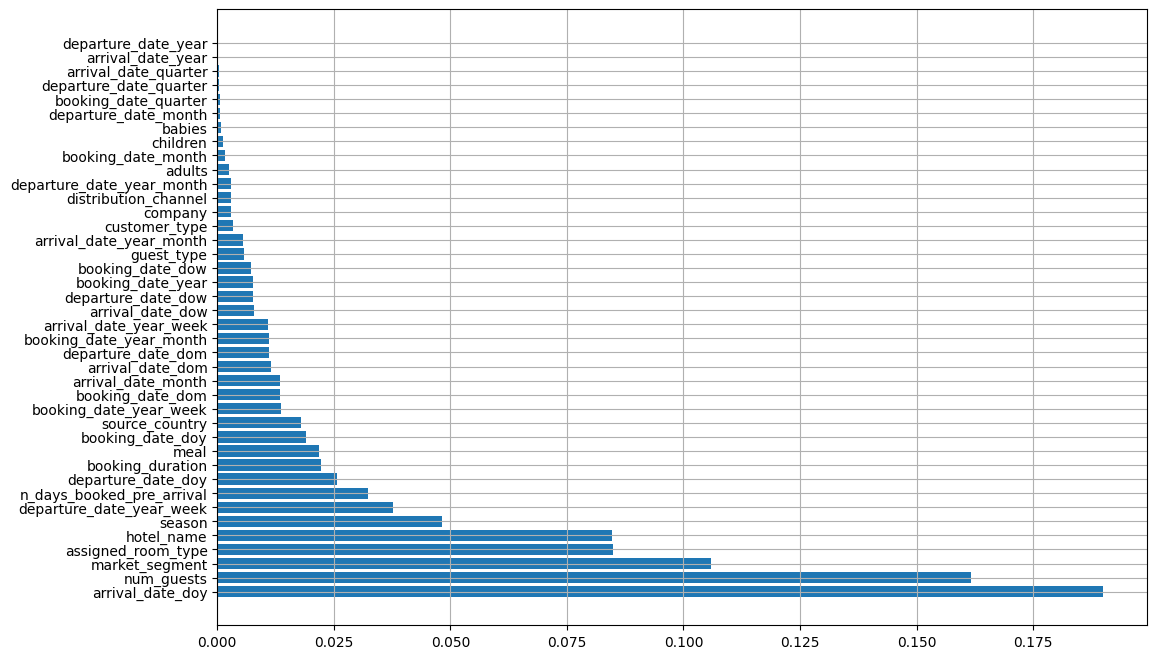

In [51]:
# Let's see what the feature importances learnt by the model
df_imp = pd.DataFrame(
    {
        "feature": input_cols, 
        "importance": mdl.feature_importances_
    }
).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(df_imp['feature'], width=df_imp['importance'])
plt.grid(True)

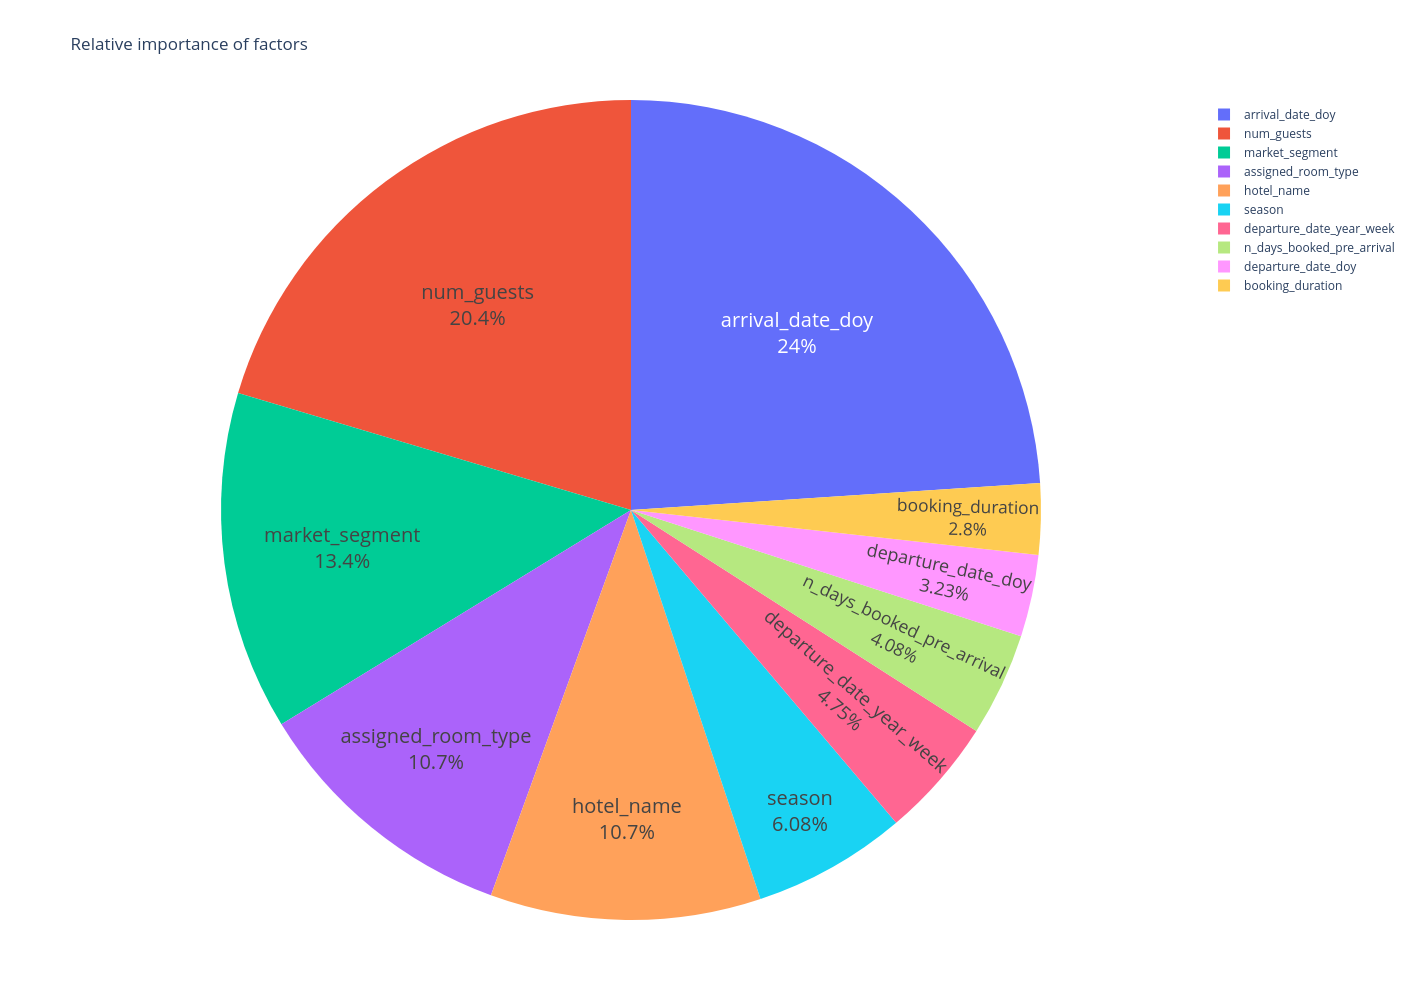

In [52]:
fig = px.pie(
    df_imp.head(10), 
    values='importance',
    names='feature',
    labels='feature',
    hover_data=['importance'],
    title='Relative importance of factors',
    width=1000, 
    height=1000
)
fig.update_traces(textposition='inside', textinfo='label+percent', textfont_size=20)
fig.show()

From the above chart we can make the following observations:
1. We didn't expect `num_guests` to be a major contributor primarily because the variance in this field is quite low (as has been observed in the previous sections). 
2. We also see that the model deems `hotel_name` and `market_segment` as an important factor that influences the price. In the previous section we have detected that `hotel_name` is an important criteria that has an influence on price.
3. The rest two in the top 5 most important criteria could be detected in our previous analyses.

The above approach of using an ML model is much better especially in these cases because we could never manually implement and observe the effects all possible combinations of each variable on one or more target variable and therefore it's easy to lose valuable insight.

This also gives the EDA a more of an exploitative flavor because eventually we may like to train a model which gives us trustworthy forecasts. However, p.s. that judging feature importances is a separate topic in itself, during modelling we usually use tools like `shap` to assess the contribution of each features. 

To finally close this topic let's visualize the distribution of prices for each of the categories in the fields - `num_guests` and `market_segment`.

In [53]:
def plot_violins(key):
    x_labels = []
    data = []
    for grp, gdf in df_l3_filtered.groupby(key):
        adr = gdf['adr'].to_numpy()
        if len(adr):
            data.append(adr)
            x_labels.append(f"{grp} ({len(gdf)})")
    
    fig = plt.figure(figsize=[15,6])
    plt.violinplot(data, widths=0.8)
    plt.title(f"Violin plots of ADR per {key}")
    plt.xticks(range(1, len(x_labels)+1), x_labels)
    plt.ylabel('ADR')
    plt.grid(True)

/tmp/ipykernel_77512/3128131761.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



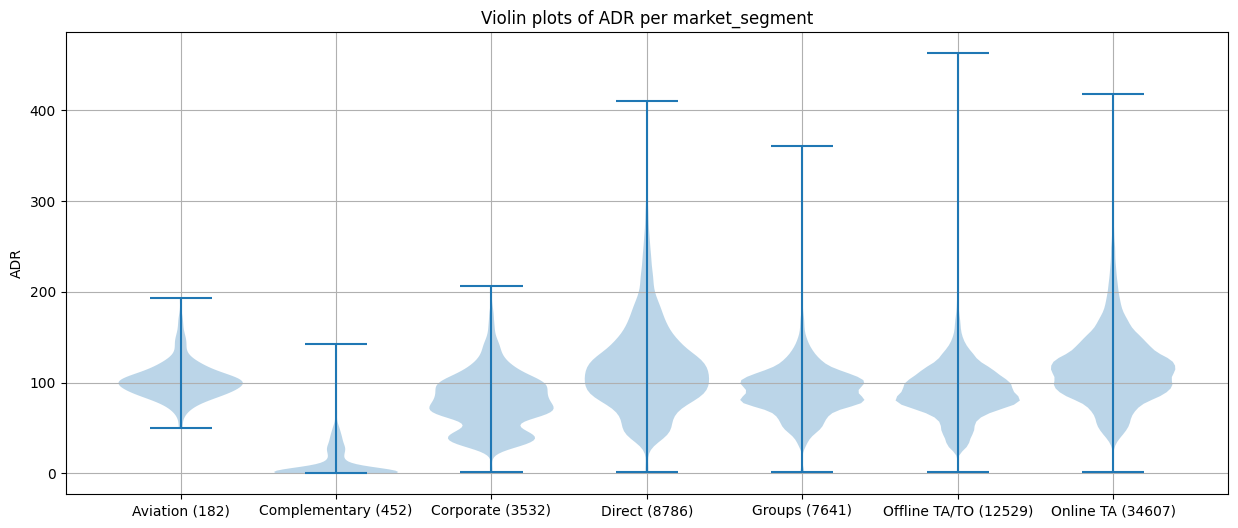

In [54]:
plot_violins('market_segment')

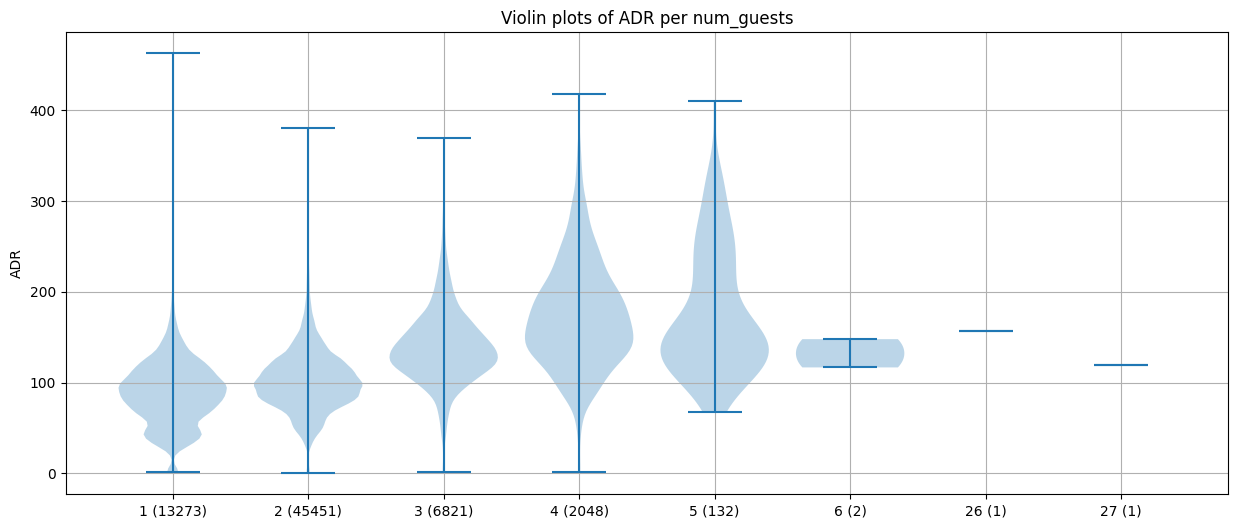

In [55]:
plot_violins('num_guests')

## Close look at the cancellations

In this section we try to probe the proportion of cancellations at the market segment level.

In [56]:
df_agg = df_l2.groupby('market_segment').agg({"is_canceled": sum, "adr": len})
df_agg['perc_cancelled'] = df_agg['is_canceled'] / df_agg['adr']
df_agg

/tmp/ipykernel_77512/1876870478.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_77512/1876870478.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.



is_canceled    adr  perc_cancelled
market_segment                                    
Aviation                 87    308        0.282468
Complementary           169    801        0.210986
Corporate              1614   6641        0.243036
Direct                 3495  15688        0.222782
Groups                11794  25022        0.471345
Offline TA/TO          9802  30343        0.323040
Online TA             23981  71094        0.337314
Undefined                 1      2        0.500000

A small conclusion that can be made here since the market segment - 'Groups' almost pay for the same ADR as 'Online TA' it would be beneficial to conduct a cohort analysis for this market segment and understand what is the discriminating criteria in this market segment that drives cancellations. 

In [57]:
df_ = df_l2.loc[df_l2['market_segment'] == 'Groups'].copy()

for col in cat_cols:
    df_[col] = LabelEncoder().fit_transform(df_[col])

mdl = DecisionTreeClassifier(random_state=RND)
mdl.fit(df_[input_cols], df_['is_canceled'])

DecisionTreeClassifier(random_state=42)

In [58]:
sklearn.metrics.balanced_accuracy_score(mdl.predict(df_[input_cols]), df_['is_canceled'], adjusted=True)

0.9850967110581388

In [59]:
df_imp = pd.DataFrame({"feature": input_cols, "importance": mdl.feature_importances_}).sort_values('importance', ascending=False)

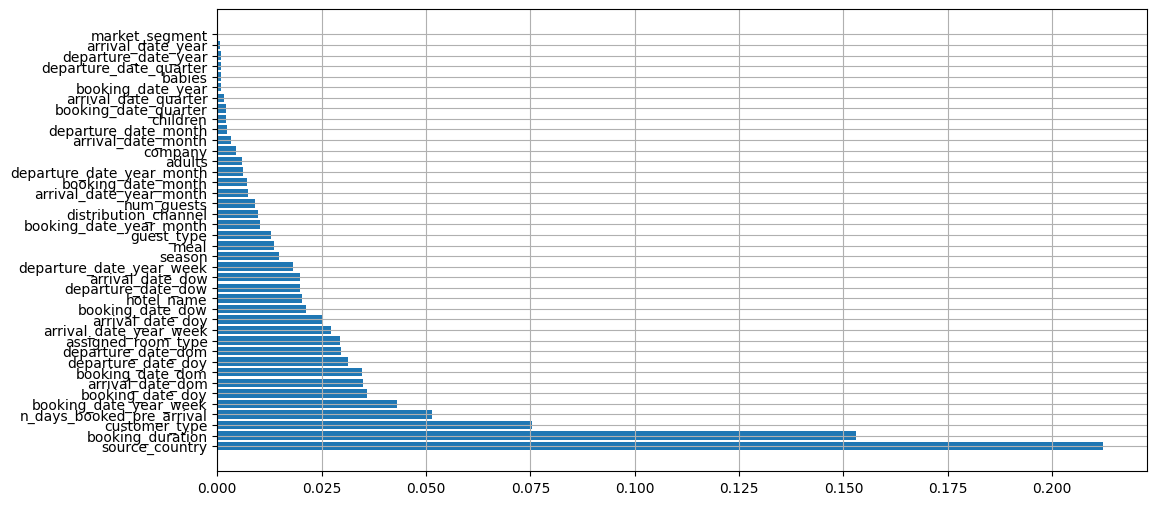

In [60]:
plt.figure(figsize=(12, 6))
plt.barh(df_imp['feature'], width=df_imp['importance'])
plt.grid(True)

Let's have a look which countries in this cohort have highest cancellations

In [61]:
(df_l2.loc[df_l2['market_segment'] == 'Groups']
.groupby('source_country')
.agg({'is_canceled': sum})
.sort_values('is_canceled', ascending=False))

/tmp/ipykernel_77512/855262470.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_77512/855262470.py:3: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.



is_canceled
source_country             
PRT                    9443
GBR                     455
ESP                     326
FRA                     312
DEU                     238
...                     ...
GUY                       0
GTM                       0
GNB                       0
GLP                       0
ZWE                       0

[170 rows x 1 columns]

Let's have a look on the complete dataset and aggregate on each country to look at the cancellations

In [62]:
canceled_stat = (df_l2
.groupby(['source_country', 'is_canceled'])
.agg({'adr': len})
.fillna(0)
.reset_index()
.pivot(columns='is_canceled', values='adr', index='source_country')
)

canceled_stat['total'] = canceled_stat[False] + canceled_stat[True]
canceled_stat['perc'] = canceled_stat[True] / canceled_stat['total']
canceled_stat.fillna(0, inplace=True)
canceled_stat.sort_values(['total','perc'], ascending=False).head()

/tmp/ipykernel_77512/2459641804.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



is_canceled       False     True    total      perc
source_country                                     
PRT             33973.0  27384.0  61357.0  0.446306
GBR             11525.0   3718.0  15243.0  0.243915
FRA             10032.0   3133.0  13165.0  0.237979
ESP              7845.0   2995.0  10840.0  0.276292
DEU              7012.0   2076.0   9088.0  0.228433

Let's see which hotels see the highest cancellations

In [63]:
canceled_stat_hotel = (df_l2
.groupby(['hotel_name', 'is_canceled'])
.agg({'adr': sum})
.fillna(0)
.reset_index()
.pivot(columns='is_canceled', values='adr', index='hotel_name')
)

canceled_stat_hotel['total'] = canceled_stat_hotel[False] + canceled_stat_hotel[True]
canceled_stat_hotel['perc'] = canceled_stat_hotel[True] / canceled_stat_hotel['total']
canceled_stat_hotel.fillna(0, inplace=True)
canceled_stat_hotel.sort_values(['total','perc'], ascending=False)

/tmp/ipykernel_77512/693296318.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_77512/693296318.py:3: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.



is_canceled                False          True         total      perc
hotel_name                                                            
Lisbon City Hotel   2.279267e+06  1.294797e+06  3.574064e+06  0.362276
Braga City Hotel    2.267765e+06  1.282573e+06  3.550337e+06  0.361254
Porto City Hotel    2.212995e+06  1.277958e+06  3.490952e+06  0.366077
Algarve Retreat     1.678467e+06  7.331785e+05  2.411646e+06  0.304016
Duro Valley Resort  1.654191e+06  7.254266e+05  2.379617e+06  0.304850

# Conclusions

## What implications do your findings from the customer analysis have for the hotel chain’s pricing strategy?

Based on the above data and the analyses therein we could suggest a multi-faceted approach. This could broadly entail the following steps:
1. Cohort analysis - We should do a sensible grouping of guests with one or more grouping keys e.g. guests from EU or not from EU, couples or families, number of guests < 4 or more,  peak-season or off-season etc. Each segment would potentially behave differently on different metrics.
2. Since most of the bookings happen during the first month of the year and are done via 'Online TA' channel - in order to maximize revenue the hotel chain could collaborate with the online channel partner and carry out pricing campaigns exactly during that time period. These could range from offering attractive prices for some room types to recommending suitable rooms. The hotel chain could run A/B tests to try out newer pricing strategies.

## What implications do your findings from the pricing analysis have for the hotel chain’s pricing strategy?

A few more points:
1. For each of the customer segments above the hotel chain could assess their respective elasticity i.e. change in demand wrt change in prices. This would already allow them to fine tune the prices (maybe increase in whichever segment its possible) but at the same time staying within a certain threshold so that they don't lose customers.
2. In the above dataset, we could not uniquely identify the guests - if we could identify them then we could have gained a better understanding into each of their nuances e.g. spend-power, are they repeat guests - if they are then special prices should be recommended to them to retain them, also offer them meal or room types (at a discounted price) that are popular among other customers who are from the same segment.
3. Overall, in order to maximize any KPI (revenue or profit) the hotel chain needs to implement an optimization engine that is driven by demand. Needless to mention by "demand" here we mean "future demand".
4. Looking at the cancellations, here are few more observations:
   * the market segment - 'Groups' see the most cancellations.
   * the country 'PRT' see highest cancellations (approx 45%).
   * the "City" hotels lose much more in revenue (approx 6 percentage points, half million in euro) compared to the other hotels.